In [1]:
# -appliquer sclaer sur modeles à optimiser (randomforest...
# -pipeline
# -installer un environnement

In [2]:
""" depuis terminal : 
python -m venv oc7_venv
source oc7_venv/bin/activate
pip install ipykernel
python -m ipykernel install --user --name=oc7_venv --display-name "OC7 Environment"
"""


"""
supression de kernel
jupyter kernelspec list
jupyter kernelspec remove [nom_du_kernel]
deactivate
rm -rf [chemin_vers_oc7_venv]
"""

"""
lister les dependencies installées
pip list
les enregistrer dans un fichier
pip freeze > requirements.txt

"""

"""/Users/laureagrech/oc7_venv/bin/python"""

'/Users/laureagrech/oc7_venv/bin/python'

In [3]:
#pip install dill numpy pandas scikit-learn hyperopt xgboost lightgbm imbalanced-learn lime shap evidently matplotlib seaborn

In [4]:
%%capture captured_output
!pip show pandas

# Set up

Python librairies imports :

In [5]:
%%capture captured_output
!pip install jupyter_ai

In [6]:
#%%capture captured_output
#!pip install jupyter_ai_magics

In [7]:
%%capture captured_output
!pip install hyperopt
!pip install xgboost
!pip install lime
!pip install shap
!pip install evidently

In [8]:
!pip install dill

In [9]:
# File system management
import os
import pickle
import dill

from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler 

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define work location :

Load data :

In [10]:
pwd

'/Users/laureagrech/Desktop/OC7/notebooks'

# import data 

In [11]:
# Load data
data = pd.read_csv("../data/processed/train_feature_engineering_sample.csv")
data_test = pd.read_csv("../data/processed/test_feature_engineering_sample.csv")

In [12]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,104589.0,0.0,0,0,1,0,0,135000.0,133659.0,12388.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,223615.0,0.0,0,1,0,0,2,110250.0,472500.0,44991.0,...,False,True,0.0125,1.0,0.0125,False,False,0.0,0.0,0.0
2,315031.0,0.0,0,1,0,1,2,117000.0,675000.0,28728.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,130862.0,0.0,0,0,1,0,0,135000.0,592560.0,32274.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140528.0,0.0,0,1,1,0,1,180000.0,715095.0,48109.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,218796.0,0,1,0,0,0,103500.0,280170.0,29547.0,0.018029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202006.0,0,1,0,0,1,202500.0,383787.0,33070.5,0.018850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123688.0,0,1,0,0,1,157500.0,440784.0,34956.0,0.002134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,389440.0,0,1,0,0,0,90000.0,189000.0,12757.5,0.015221,...,False,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0
4,166255.0,0,1,0,0,0,135000.0,450000.0,19197.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Functions

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [15]:
# Function to display the confusion matrix
# y_true : array-like of shape (n_samples,) - True labels of the data
# y_pred : array-like of shape (n_samples,) - Predicted labels from the model
# model_name : str - Name of the model for which the confusion matrix is displayed
def display_confusion_matrix(y_true, y_pred, model_name):
    # Compute the confusion matrix and unravel it into four main components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Print the model name for which the confusion matrix is displayed
    print(f"Matrice de confusion pour {model_name} :")
    # Print the individual components of the confusion matrix: true negative, false positive, false negative and true positive
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    # Print a new line for better readability
    print("\n")

In [16]:
# Fonction améliorée pour calculer et tracer la courbe ROC avec le seuil optimal
# La fonction "compute_roc_curve" est utilisée pour évaluer et visualiser la performance d'un modèle de classification binaire.
# 
# Dans le contexte de ce projet, elle permet de tracer la courbe ROC, qui montre la capacité du modèle à distinguer entre les classes 
# en calculant les taux de faux positifs (FPR) et de vrais positifs (TPR) à plusieurs seuils de classification.
# 
# L'aire sous la courbe ROC (AUC) est aussi calculée, ce qui fournit une mesure quantifiable de la performance du modèle : 
# plus l'AUC est proche de 1, meilleure est la performance du modèle.
# 
# Un aspect avancé de cette fonction est la possibilité de trouver et afficher le seuil optimal, 
# celui où la somme des distances entre le taux de vrais positifs et de faux positifs est minimale. 
# Cette fonctionnalité est activée en réglant "disp_best_th" à True.
# 
# En résumé, cette fonction aide à comprendre et à illustrer comment un modèle travaille sur un ensemble de données, 
# ce qui est essentiel dans l'évaluation pour un meilleur choix de modèle ou de seuil de classification pour le projet.

In [17]:
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Calculate necessary metrics for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Calculate false positive rates, true positive rates, and thresholds
    auc = roc_auc_score(y_test, y_pred_proba)  # Calculate the Area Under Curve (AUC)
    
    # Create a new figure to plot the curve
    plt.figure()
    plt.title(model_name + ": ROC curve")  # Add a title to the ROC curve

    # Plot the reference line y=x (baseline)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')  # Dashed line as baseline

    # Plot the actual ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format(auc))  # Add the legend with the AUC value

    if disp_best_th:
        # Calculate the best threshold based on the minimum distance to (0,1)
        o_tpr = tpr[np.argmin(np.abs(fpr + tpr - 1))]  # Optimal true positive rate
        o_fpr = fpr[np.argmin(np.abs(fpr + tpr - 1))]  # Optimal false positive rate
        o_threshold = thresholds[np.argmin(np.abs(fpr + tpr - 1))]  # Optimal threshold

        # Display the optimal threshold point on the ROC curve
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))  # Add a point for the best threshold

    plt.ylabel('True Positive Rate')  # Label the y-axis
    plt.xlabel('False Positive Rate')  # Label the x-axis
    plt.legend(loc=4)  # Place the legend
    plt.show()  # Display the plot

    # Return the AUC score
    return auc  # Return the AUC score to evaluate model performance

In [18]:
# Fonction pour calculer les résultats de classification
# La fonction `compute_classification_results` a pour objectif d'évaluer un modèle de classification binaire.
# 
# Elle est utile dans le cadre de ce projet car elle compile plusieurs métriques de performance clés qui 
# permettent d'analyser la qualité du modèle sur les données de test.
# 
# Voici un aperçu des actions réalisées par la fonction :
# 
# 1. **Prédictions de Probabilité :** Elle calcule la probabilité que chaque instance appartienne à la classe positive 
#    (classe 1) à l'aide de la méthode `predict_proba`. Cette étape est cruciale pour des mesures telles que la courbe ROC.
# 
# 2. **Prédictions de Classes :** Elle produit les étiquettes de classe en utilisant la méthode `predict`.
# 
# 3. **Matrice de Confusion :** La fonction affiche une matrice de confusion pour visualiser les résultats, 
#    en montrant les vrais positifs (TP), faux positifs (FP), vrais négatifs (TN) et faux négatifs (FN).
# 
# 4. **Courbe ROC et AUC :** Elle trace la courbe ROC et calcule l'aire sous la courbe (AUC), ce qui donne un indicateur 
#    de la capacité du modèle à classer correctement les instances entre les deux classes.
# 
# 5. **Rapport de Classification :** Un rapport de classification est généré pour fournir des mesures telles que 
#    la précision, le rappel et le score F1 pour chaque classe.
# 
# 6. **F-beta Score :** Elle calcule le score F-beta, une généralisation du score F1 qui permet de pondérer 
#    l'importance relative de la précision et du rappel avec le paramètre beta.
# 
# L'analyse des résultats retournés par cette fonction aide à évaluer les forces et faiblesses du modèle, 
# en permettant des décisions éclairées quant à l'amélioration des performances du modèle dans ce projet. 
# Elle est particulièrement utile pour comparer différents modèles de classification et sélectionner le plus approprié.

In [19]:
def compute_classification_results(model, model_name, x_test, y_test, beta=2, disp_best_th=False):
    # Predict the probability of the positive class (e.g., defaulting on a loan)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Predict the class labels for the test data
    y_pred = model.predict(x_test)

    # Display the confusion matrix to illustrate true vs. predicted labels
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Plot the ROC curve and calculate the AUC score to evaluate model performance
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name, disp_best_th=disp_best_th)

    # Generate a classification report with metrics such as precision, recall, and F1-score
    classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(classification_report)

    # Calculate the F-beta score, emphasizing recall over precision when beta > 1
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    print(f"F-beta score (beta={beta}) =", fbeta)

    # Return the computed performance metrics
    return fbeta, auc_score, classification_report

In [20]:
# Function to extract the best model from Hyperopt optimization trials
def trials_best_model(trials):
    # Filter the trials to include only those with a successful status
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    
    # Extract loss values from valid trials and convert them to float
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    
    # Identify the index of the trial with the minimum loss value
    min_loss_idx = np.argmin(losses)
    
    # Retrieve the trial object corresponding to the best (minimum loss) result
    best_trial_obj = valid_trial_list[min_loss_idx]
    
    # Print the loss value of the best trial for reference
    print("Best result :", best_trial_obj['result']['loss'])
    
    # Return the model associated with the best trial
    return best_trial_obj['result']['model']

# MLFlow

MLflow est utilisé pour suivre et enregistrer les résultats d'entraînement de modèles de machine learning. 

MLflow est un outil de gestion du cycle de vie des modèles, qui permet de logger (enregistrer) des hyperparamètres, des métriques,

des artefacts (comme les modèles eux-mêmes) et
d'autres informations pertinentes pour le suivi des expériences de machine learning.

Set up of MLFlow tracking.

In [21]:
%%capture captured_output
!pip install mlflow

La fonction log_mlflow est conçue pour enregistrer les paramètres, les métriques, et le modèle dans l'environnement MLflow.

In [22]:
import mlflow

# Définir l'emplacement pour les logs MLflow (par exemple, un dossier spécifique)
mlflow.set_tracking_uri("../mlruns")

In [23]:
pwd


'/Users/laureagrech/Desktop/OC7/notebooks'

In [24]:
import mlflow

# Define the name of the MLflow experiment
defined_name = 'credit_scoring'

# Set up the experiment. This will create a new experiment if one doesn't exist with this name already.
mlflow.set_experiment(experiment_name)

# Start a new run to log parameters and metrics under the defined experiment
with mlflow.start_run() as run:
    # Log parameters. Here, 'param1' is a placeholder for any parameter you want to track, and '5' is its value.
    mlflow.log_param("param1", 5)
    
    # Log metrics. 'metric1' is a name given to the metric, and '0.89' is its value, representing model performance.
    mlflow.log_metric("metric1", 0.89)

# The run is ended automatically after exiting the 'with' block, ensuring all logged data is saved.

In [25]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

#mlflow ui


In [26]:


# Vérifier que l'expérimentation est bien créée
print("Expérimentation définie :", mlflow.get_experiment_by_name("credit_scoring"))


Expérimentation définie : <Experiment: artifact_location='/Users/laureagrech/Desktop/OC7/notebooks/../mlruns/379845844456180481', creation_time=1729106380864, experiment_id='379845844456180481', last_update_time=1729106380864, lifecycle_stage='active', name='credit_scoring', tags={}>


# Data preparation

In [27]:
"""# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42"""

"# Define target and features\nTARGET = 'TARGET'\ntarget = data[TARGET].to_numpy()\nfeatures = data.drop(columns=TARGET).to_numpy()\nfeatures_names = data.drop(columns=TARGET).columns.to_list()\n\n# Define training set size\nTRAIN_SIZE = 0.8\n\n# Define random state\nRANDOM_STATE = 42"

## Missing values

In [28]:
"""# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))"""

'# Check missing values\nnan_values = data.isna().sum().sum()\nprint("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))'

I fill the missing values with a simple imputer.

In [29]:
"""# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)"""

"# Create imputer\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\n\n# Fit to data\nimp_mean.fit(features)\n\n# Transform data\nfeatures_fill = imp_mean.transform(features)"

## Split data

I split the data into training and testing sets.

In [30]:
"""# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)"""

'# Split dataset (filled)\nx_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)'

In [31]:
"""# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)"""

'# Define stratifiedKfold\nstrat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)'

## Balance data

In [32]:
"""y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))"""

'y_train_counter = Counter(y_train)\nprint("Training target statistics:", y_train_counter)\nprint("Testing target statistics:", Counter(y_test))\n\n# Print ratio\nprint("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))'

I will define a pipeline that first transforms the training dataset with SMOTE then fits the model.

In [33]:
"""# Define oversampling and undersampling
oversampling = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
undersampling = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('oversampling', oversampling), ('undersampling', undersampling)]
# steps = [('over', over)]

pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)
#fit_resample prend les données dentraînement (x_train, y_train) comme entrée.
#Il applique d'abord SMOTE pour suréchantillonner la classe minoritaire.
#Ensuite, il applique RandomUnderSampler pour réduire le nombre d'exemples de la classe majoritaire."""
"""
print("Training target statistics:", Counter(y_res)) # Statistiques après rééchantillonnage
print("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test"""

'\nprint("Training target statistics:", Counter(y_res)) # Statistiques après rééchantillonnage\nprint("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test'

In [34]:
"""print("Training target statistics:", Counter(y_res)) 
print("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test"""


'print("Training target statistics:", Counter(y_res)) \nprint("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test'

In [35]:
"""# Display barplot of distribution to see Smote impact on data
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()"""

'# Display barplot of distribution to see Smote impact on data\nclass_distr_df = pd.DataFrame({\'training set\': [\'unbalanced\', \'unbalanced\', \'balanced\', \'balanced\'],\n                               \'target\': [\'Class 0\', \'Class 1\', \'Class 0\', \'Class 1\'],\n                               \'count\': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})\n\n# Display barplot\nsns.barplot(class_distr_df, x=\'training set\', y=\'count\', hue=\'target\')\nplt.title("Target distribution")\nplt.show()'

## Custom loss function

Rule : cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)

Le make scorer fonctionne bien pour calculer un score métier en se basant sur la matrice de confusion, avec une pénalisation spécifique pour les faux négatifs.
On adapte le paramètre beta pour le F-beta score dans make_scorer. Le F-beta score permet de donner plus ou moins d'importance au Recall (sensibilité) ou à la Précision, selon la valeur de beta.

### avec beta score

In [36]:
from sklearn.metrics import fbeta_score

# Exemple avec beta = 2 pour accorder plus d'importance au Recall
# Fonction pour calculer le F-beta score avec un beta ajusté
def fbeta_scorer(beta=2):
    return make_scorer(fbeta_score, beta=beta)

In [37]:
mlflow.end_run()

In [38]:
import os
import time
import pandas as pd
import joblib
import mlflow
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier


def train_and_log_model(model, model_name, data, target_name='TARGET', train_size=0.8, random_state=42, betas=[0.5, 1, 2, 2.5]):
    # Start the timer to measure the training duration
    start_time = time.time()
    
    # Separate the target feature from the data and convert it to a NumPy array
    target = data[target_name].to_numpy()
    
    # Drop the target column from the dataset and convert the remaining features to a NumPy array
    features = data.drop(columns=target_name).to_numpy()

    # Split the dataset into training and testing sets using a defined train/test size and random state for reproducibility
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Create a preprocessing pipeline that includes:
    # - Imputation of missing values using the mean strategy
    # - Standard scaling of features
    # - Oversampling of the minority class using SMOTE
    # - Undersampling of the majority class
    # - Fitting the model
    preprocess_pipeline = ImbPipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state)),
        ('model', model)
    ])

    # Initialize a list to store results
    results = []
    
    # Loop over each specified beta value to calculate the F-beta score
    for beta in betas:
        # Define an F-beta score function with the current beta value
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)
        
        # Start a new MLflow run for logging parameters and metrics
        with mlflow.start_run(run_name=f"{model_name}_beta_{beta}"):
            
            # Fit the preprocessing pipeline on the training data
            preprocess_pipeline.fit(x_train, y_train)
            
            # Make predictions on the test set
            y_pred = preprocess_pipeline.predict(x_test)
            # Predict probabilities for the positive class
            y_pred_proba = preprocess_pipeline.predict_proba(x_test)[:, 1]

            # Calculate accuracy, AUC score, and F-beta score
            accuracy = accuracy_score(y_test, y_pred)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            fbeta = fbeta_score(y_test, y_pred, beta=beta)
            
            # Generate a classification report
            clf_report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

            # Log model parameters and calculated metrics to MLflow
            mlflow.log_params({"model_type": model_name, "beta": beta})
            mlflow.log_metrics({"accuracy": accuracy, "AUC": auc_score, "F-beta": fbeta})

            # Append the results for the current beta
            results.append({
                'Beta': beta,
                'AUC': auc_score,
                'Accuracy': accuracy,
                'F-beta': fbeta,
                'Report': clf_report
            })

            # Define a path to save the trained model
            model_path = f'../models/{model_name}_beta_{beta}_pipeline.pkl'
            # Save the preprocessing pipeline and model to the specified path
            joblib.dump(preprocess_pipeline, model_path)
            # Log the saved model artifact to MLflow
            mlflow.log_artifact(model_path)

    # Calculate the duration taken for the entire training process
    duration = time.time() - start_time
    # Log the training duration as a metric to MLflow
    mlflow.log_metric("training_duration_seconds", duration)

    # Return the last beta value used, AUC score, accuracy, F-beta score, classification report, and training duration
    return beta, auc_score, accuracy, fbeta, clf_report, duration

In [39]:
mlflow.end_run()

In [40]:
# Example usage
model = DummyClassifier(strategy='most_frequent', random_state=42)
model_name = 'DummyModel'

beta, auc_score, accuracy, fbeta, clf_report, duration = train_and_log_model(model, model_name, data, betas=[0.5, 1, 2, 2.5])

In [41]:
mlflow.end_run()

In [42]:
model = LogisticRegression(solver='liblinear', random_state=42)
model_name = 'LogisticRegression'
beta, auc_score, accuracy, fbeta, clf_report, duration = train_and_log_model(model, model_name, data, betas=[0.5, 1, 2, 2.5])

In [43]:
display(clf_report)

{'0.0': {'precision': 0.952,
  'recall': 0.7158527954706299,
  'f1-score': 0.8172086447182387,
  'support': 5652.0},
 '1.0': {'precision': 0.1551814834297738,
  'recall': 0.591182364729459,
  'f1-score': 0.24583333333333332,
  'support': 499.0},
 'accuracy': 0.7057389042432125,
 'macro avg': {'precision': 0.5535907417148869,
  'recall': 0.6535175801000443,
  'f1-score': 0.531520989025786,
  'support': 6151.0},
 'weighted avg': {'precision': 0.887358081650375,
  'recall': 0.7057389042432125,
  'f1-score': 0.770855810970707,
  'support': 6151.0}}

### avec loss function

In [45]:
"""Fonction pour calculer le score personnalisé basé sur la matrice de confusion et F-beta¶
def cost_score_function(y_true, y_pred, y_pred_proba, beta=2): # Matrice de confusion tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Custom profit score basé sur la règle métier
cost_score = (tp * 0) + (tn * 0) - (fp * 10) - (fn * 100)
cost_score = (- (fp * 10) - (fn * 100))/(-fp-fn))# normaliser pour avoir sortie positive entre 0 et 1

# Calcul du F-beta score avec le beta ajusté
#fbeta = fbeta_score(y_true, y_pred, beta=beta)

# Combiner les deux scores 
#combined_score = profit_score + fbeta * 100  # Mettre plus de poids sur F-beta si nécessaire
return combined_score
#return combined_score"""

'Fonction pour calculer le score personnalisé basé sur la matrice de confusion et F-beta¶\ndef cost_score_function(y_true, y_pred, y_pred_proba, beta=2): # Matrice de confusion tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()\n\n# Custom profit score basé sur la règle métier\ncost_score = (tp * 0) + (tn * 0) - (fp * 10) - (fn * 100)\ncost_score = (- (fp * 10) - (fn * 100))/(-fp-fn))# normaliser pour avoir sortie positive entre 0 et 1\n\n# Calcul du F-beta score avec le beta ajusté\n#fbeta = fbeta_score(y_true, y_pred, beta=beta)\n\n# Combiner les deux scores \n#combined_score = profit_score + fbeta * 100  # Mettre plus de poids sur F-beta si nécessaire\nreturn combined_score\n#return combined_score'

On utilisera uniquement le F-beta score pour optimiser le modèle, en ayant en tête l' objectif principal de minimisation des faux négatifs (FN).

Le F-beta score est idéal pour cette tâche, car on peut ajuster le paramètre beta pour donner plus de poids au recall (rappel), ce qui est crucial pour réduire les faux négatifs. 
Un faux négatif se produit lorsqu'une personne qui ne peut pas rembourser le crédit est identifiée à tort comme pouvant le faire. 

En augmentant le recall, on maximise la détection des vrais cas de clients qui ne peuvent pas rembourser, ce qui réduit les faux négatifs

La matrice de confusion est un tableau qui décompose les prédictions d'un modèle de classification en quatre catégories :

TN (True Negatives True Target=0) : Cas où le modèle a correctement prédit la classe négative (un client remboursera son crédit et le modèle l'a bien prédit).

FP (False Positives Faux Target =1) : Cas où le modèle a prédit la classe positive, mais c'était en réalité négatif (un client est prédit comme ne remboursant pas alors qu'il rembourse en réalité).

FN (False Negatives Faux Target =0) : Cas où le modèle a prédit la classe négative, mais c'était en réalité positif (un client est prédit comme remboursant, mais il ne rembourse pas en réalité).

TP (True Positives Vrai Target =1) : Cas où le modèle a correctement prédit la classe positive (un client ne remboursera pas et le modèle l'a bien prédit).

# Classification

Les métriques de précision, rappel, F1-score, support, et un score métier personnalisé sont couramment utilisées pour évaluer la performance des modèles de classification en machine learning, spécialement dans les contextes où les décisions ont des conséquences financières ou d'autres impacts importants.

1. Précision (Precision)
La précision mesure la justesse des prédictions positives faites par le modèle. Elle est définie comme le ratio des vrais positifs (TP) par rapport à la somme des vrais positifs et des faux positifs (FP):


Interprétation : Une précision élevée indique qu'une grande proportion des identifications positives du modèle sont correctes.

2. Rappel (Recall) ou Sensibilité
Le rappel mesure la capacité du modèle à détecter tous les cas positifs réels. Il est défini comme le ratio des vrais positifs par rapport à la somme des vrais positifs et des faux négatifs (FN):

Rappel
: Un rappel élevé signifie que le modèle est capable de détecter une grande partie des cas positifs réels. C'est crucial dans les situations où ne pas détecter les positifs (comme les maladies ou les fraudes) peut avoir de graves conséquences.

3. F1-Score
Le F1-score est la moyenne harmonique de la précision et du rappel. Il combine les deux métriques en une seule, ce qui est particulièrement utile lorsque vous avez besoin d'un équilibre entre la précision et le rappel:
Interprétation : Le F1-score est particulièrement utile quand les coûts des faux positifs et faux négatifs sont très équilibrés, ou lorsque les distributions des classes sont déséquilibrées.

4. Support
Le support est le nombre de cas réels pour chaque classe dans les données testées. Pour chaque classe, il indique combien d'exemples de cette classe existent dans les données.

Interprétation : Le support n'influence pas directement la performance du modèle mais donne un contexte sur la significativité des métriques de performance comme le rappel et la précision.

5. Score Métier
Un score métier est une métrique personnalisée qui évalue la performance du modèle selon des critères spécifiquement importants pour l'entreprise ou l'application. Il peut intégrer des coûts ou des bénéfices associés aux différentes prédictions du modèle (TP, FP, TN, FN). Par exemple :

Interprétation : Cette métrique est utilisée pour maximiser le rendement économique du modèle ou pour minimiser les risques spécifiques. Elle aide à prendre des décisions stratégiques sur le déploiement du modèle en production en alignant les objectifs du modèle avec les objectifs financiers ou opérationnels de l'organisation.
Ensemble, ces métriques fournissent une vue complète de la performance d'un modèle de classification, aidant les développeurs à comprendre ses forces et ses faiblesses et à faire des ajustements pour améliorer son efficacité dans des contextes pratiques.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to display the confusion matrix for a classification model

def display_confusion_matrix(y_true, y_pred, model_name):
    # Compute the confusion matrix from true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Decompose the confusion matrix into individual components

    # Print a text summary of the confusion matrix components
    print(f"Confusion Matrix for {model_name} :")
    print(f"TN (True Negatives): {tn}")  # Correctly predicted negatives
    print(f"FP (False Positives): {fp}")  # Incorrectly predicted positives
    print(f"FN (False Negatives): {fn}")  # Incorrectly predicted negatives
    print(f"TP (True Positives): {tp}")  # Correctly predicted positives

    # Create an annotated version of the matrix with labels and their values
    cm_annot = [[f'TN\n{tn}', f'FP\n{fp}'],
                [f'FN\n{fn}', f'TP\n{tp}']]

    # Visual display using seaborn's heatmap
    plt.figure(figsize=(6, 6))  # Set the figure size for better clarity
    sns.heatmap(cm, annot=cm_annot, fmt='', cmap="Blues", cbar=False, 
                xticklabels=["Class 0 (Predicted)", "Class 1 (Predicted)"], 
                yticklabels=["Class 0 (Actual)", "Class 1 (Actual)"])
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)  # Add a title with the model's name
    plt.ylabel('Actual Class', fontsize=12)  # Set y-axis label
    plt.xlabel('Predicted Class', fontsize=12)  # Set x-axis label
    
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()  # Display the plot

In [48]:
# This function computes various classification metrics for a given model and test data
# It includes confusion matrix visualization, ROC curve plotting, AUC score calculation, and F-beta score evaluation

def compute_classification_results(model, model_name, x_test, y_test, beta=2):
    # Predict the probability of the positive class (class 1, usually indicating default in credit scoring)
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # Predict class labels for the test set
    y_pred = model.predict(x_test)

    # Display the confusion matrix to visualize the performance of the classification model
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Plot the ROC curve and calculate the AUC (Area Under the Curve) score for model evaluation
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Generate a classification report with precision, recall, f1-score, and support metrics
    classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(classification_report_df)

    # Calculate the F-beta score, which is a weighted harmonic mean of precision and recall
    # The beta parameter determines the weight of recall in the combined score
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    print(f"F-beta score (beta={beta}) =", fbeta)

    # Return the F-beta score, AUC score, and detailed classification report
    return fbeta, auc_score, classification_report_df

In [49]:
# Function to compute and plot the ROC curve
def compute_roc_curve(y_true, y_pred_proba, model_name):
    # Calculate the false positive rate and true positive rate for various threshold levels
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    # Compute the Area Under the Curve (AUC) score to quantify the overall ability of the model
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    # Create a new figure for the ROC curve plot
    plt.figure()
    # Plot the ROC curve using false positive rate and true positive rate
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    # Add a diagonal line as a reference for a model with no discriminative ability
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    # Set limits for the x-axis from 0 to 1
    plt.xlim([0.0, 1.0])
    # Set limits for the y-axis from 0 to a little above 1 for better visualization
    plt.ylim([0.0, 1.05])
    # Label the x-axis as False Positive Rate
    plt.xlabel('Taux de Faux Positifs')
    # Label the y-axis as True Positive Rate
    plt.ylabel('Taux de Vrais Positifs')
    # Add a title to the plot with the model name
    plt.title(f'ROC Curve for {model_name}')
    # Add a legend to the lower-right corner of the plot
    plt.legend(loc="lower right")
    # Display the plot
    plt.show()

    # Return the AUC score as a measure of model's performance
    return auc_score

# Models pipeline générique (comparaison des différents modèles)

In [50]:
"""
Utilisation d' une pipeline de prétraitement pour les étapes qui peuvent être appliquées de manière
uniforme aux ensembles d'entraînement et de test (comme l'imputation 
et la normalisation). 

Application du rééquilibrage uniquement aux données d'entraînement après le prétraitement.
"""

"\nUtilisation d' une pipeline de prétraitement pour les étapes qui peuvent être appliquées de manière\nuniforme aux ensembles d'entraînement et de test (comme l'imputation \net la normalisation). \n\nApplication du rééquilibrage uniquement aux données d'entraînement après le prétraitement.\n"

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, fbeta_score
import os
import joblib
import mlflow
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score
from mlflow.models.signature import infer_signature

# Define a function to create a custom f-beta scorer
# This allows us to adjust the importance of precision vs recall
# by changing the beta parameter

def fbeta_scorer(beta=2):
    return make_scorer(fbeta_score, beta=beta)

# Define a function that trains a model and logs its performance using MLflow
# This function will set up a data processing and modeling pipeline
# and use cross-validation to evaluate model performance

def train_and_log_model(model, model_name, data, target_name='TARGET', train_size=0.8, random_state=42, beta=2):
    # Record start time for measuring execution duration
    start_time = time.time()

    # Prepare the dataset by extracting features and target variables
    target = data[target_name].to_numpy()
    features = data.drop(columns=target_name).to_numpy()

    # Handle missing values by replacing them with the mean of each feature
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    features_fill = imp_mean.fit_transform(features)

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=train_size, random_state=random_state)

    # Create a pipeline that includes preprocessing and the model
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=42)),  # Apply oversampling to balance classes
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=42)),  # Apply undersampling
        ('model', model)  # The classifier model to use
    ])

    # Start an MLflow run to log parameters, metrics, and artifacts
    with mlflow.start_run(run_name=f"{model_name}_with_pipeline"):
        # Train the model using the training data
        pipeline.fit(x_train, y_train)

        # Log the trained model in MLflow
        mlflow.sklearn.log_model(pipeline, f"{model_name}_model")

        # Compute and log basic evaluation metrics
        accuracy = pipeline.score(x_test, y_test)
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("oversampling_strategy", "0.5")
        mlflow.log_param("undersampling_strategy", "1")
        mlflow.log_metric("accuracy", accuracy)

        # Save the training pipeline to a file for later use
        os.makedirs('../models', exist_ok=True)
        joblib.dump(pipeline, f'../models/{model_name}_pipeline.pkl')
        print(f"Model {model_name} saved as models/{model_name}_pipeline.pkl")

        # Predict the probabilities and the class predictions for the test set
        y_pred_proba = pipeline.predict_proba(x_test)[:, 1]
        y_pred = pipeline.predict(x_test)

        # Display the confusion matrix and ROC curve
        fbeta, auc_score, clf_report = compute_classification_results(pipeline, model_name, x_test, y_test, beta=beta)

        # Log additional evaluation metrics in MLflow
        mlflow.log_metric("F-beta score", fbeta)
        mlflow.log_metric("AUC score", auc_score)
        mlflow.log_metric("precision", clf_report.loc['weighted avg', 'precision'])
        mlflow.log_metric("recall", clf_report.loc['weighted avg', 'recall'])
        mlflow.log_metric("f1_score", clf_report.loc['weighted avg', 'f1-score'])

        # Save the classification report to a CSV file
        clf_report_filename = f'../models/{model_name}_classification_report.csv'
        clf_report.to_csv(clf_report_filename)
        mlflow.log_artifact(clf_report_filename)

        # Perform cross-validation using the custom f-beta scorer and log the mean score
        scorer = fbeta_scorer(beta=beta)
        cross_val_fbeta = cross_val_score(pipeline, features_fill, target, scoring=scorer, cv=5)
        mlflow.log_metric("mean_fbeta_cross_val", np.mean(cross_val_fbeta))
        print(f"Cross-validated F-beta score (beta={beta}): {np.mean(cross_val_fbeta)}")

        # Record end time and calculate the duration of the training process
        end_time = time.time()
        duration = end_time - start_time
        mlflow.log_metric("training_duration_seconds", duration)
        print(f"Execution time for {model_name} : {duration:.2f} seconds")

    # Return the evaluation scores
    return auc_score, accuracy, fbeta, clf_report, duration

# Entraînement des modèles

In [55]:
!pip install imbalanced-learn

In [56]:
import time
from imblearn.pipeline import Pipeline as ImbPipeline

In [57]:
from sklearn.model_selection import train_test_split

# Load necessary function from scikit-learn to split the dataset into train and test sets

# Example of data preparation and train/test split outside of a function context
# Specify the target variable used for predictions
TARGET = 'TARGET'

# Convert the target column in the DataFrame to a NumPy array for ease of processing
# The target variable represents the output or the dependent variable for the model

target = data[TARGET].to_numpy()

# Extract features from DataFrame by dropping the target column
# Convert them to a NumPy array for consistent input format to ML algorithms
# These features are the inputs or independent variables the model will learn from
features = data.drop(columns=TARGET).to_numpy()

# Use the train_test_split function to partition the data into training and test datasets
# Set the training set to be 80% and the test set to be 20% of the entire dataset
# Specify a random state for reproducibility, ensuring consistent splitting between runs
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)

## Dummy Classifier

In [ ]:
# Explanation of Usage Differences between Dummy Classifier, Logistic Regression, Random Forest, LightGBM, and XGBoost

## 1. Dummy Classifier
- **Purpose**: A simple classifier used as a baseline for comparison.
- **Usage**: It makes predictions using simple rules, such as predicting the most frequent class or stratified sampling.
- **Pros**: Useful for understanding baseline performance without any complex learning.
- **Cons**: Not suitable for real predictive tasks as it doesn't capture data patterns.
- **When to Use**: To compare more complex models to a baseline or to ensure data processing works.

## 2. Logistic Regression
- **Purpose**: A statistical method for predicting binary classes based on a linear relationship between the input variables.
- **Usage**: Effective for problems where the relationship between the dependent and independent variables is linear.
- **Pros**: Simple to understand and implement, provides probabilities of class membership, relatively easy to interpret.
- **Cons**: Assumes a linear relationship between features and the log-odds of the outcome, which may not always be accurate in practice.
- **When to Use**: When a simple, interpretable model is preferred and the relationship between variables is expected to be linear.

## 3. Random Forest
- **Purpose**: An ensemble method that builds multiple decision trees and merges them to improve prediction accuracy.
- **Usage**: Suitable for handling tabular data, especially when there is a need for robust predictions without much parameter tuning.
- **Pros**: Handles both classification and regression, resistant to overfitting, handles missing data well.
- **Cons**: Can be computationally intensive, less interpretable than single decision trees.
- **When to Use**: When you need a quick, robust model and have enough computational resources.

## 4. LightGBM
- **Purpose**: A gradient boosting framework that uses tree-based learning algorithms.
- **Usage**: Efficient for handling large datasets with high dimensions and when fast training is essential.
- **Pros**: Fast and efficient, handles large datasets, supports parallel learning.
- **Cons**: Can be sensitive to overfitting if not properly tuned, less interpretable.
- **When to Use**: For large datasets and when time and computational efficiency are paramount.

## 5. XGBoost
- **Purpose**: An optimized distributed gradient boosting library designed to be efficient and flexible.
- **Usage**: Known for its performance and accuracy in solving classification and regression problems.
- **Pros**: Regularization reduces overfitting, flexible and supports many objective functions.
- **Cons**: Complexity in tuning parameters, can be computationally demanding.
- **When to Use**: For competitive modeling tasks on tabular data where accuracy and flexibility are important.

## Comparing Models with Dummy Classifier

Comparing complex models like Logistic Regression, Random Forest, LightGBM, and XGBoost against a Dummy Classifier is essential to ascertain the added value of the machine learning models. 
- **Baseline Performance**: The Dummy Classifier offers a baseline performance metric, so any model that performs similarly may offer little more than chance or simple prediction without learning from the data.
- **Measure of Improvement**: Seeing a significant improvement in metrics like accuracy, F1-score, or AUC over the Dummy Classifier indicates that the more sophisticated models are effectively learning patterns in the data.
- **Model Validation**: Ensures that the process of data preparation, model training, and evaluation are functioning as intended, as even a baseline model should function logically and predictably.
- **Strategic Decision**: Helps in making decisions about the complexity and resources required for the model training process, highlighting whether advanced methods are necessary for significant performance gains.

In summary, using a Dummy Classifier as a benchmark ensures that the advanced models are leveraging data insights effectively, justifying their complexity and computational cost.

In [58]:
mlflow.end_run()

2024/10/21 00:36:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model DummyClassifier saved as models/DummyClassifier_pipeline.pkl
Matrice de confusion pour DummyClassifier :
TN (True Negatives): 2838
FP (False Positives): 2814
FN (False Negatives): 228
TP (True Positives): 271


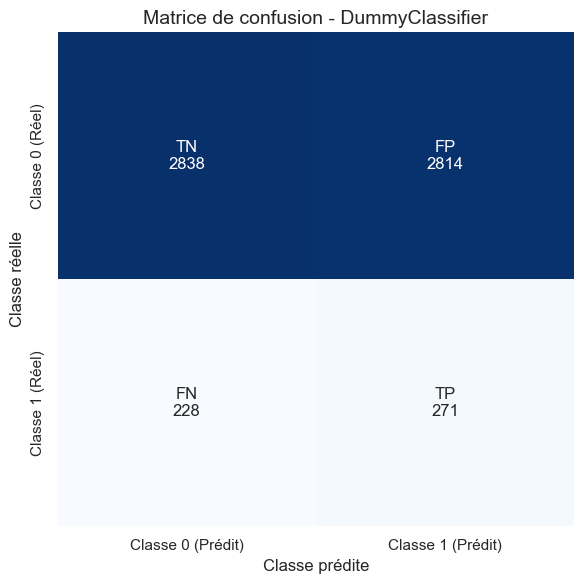

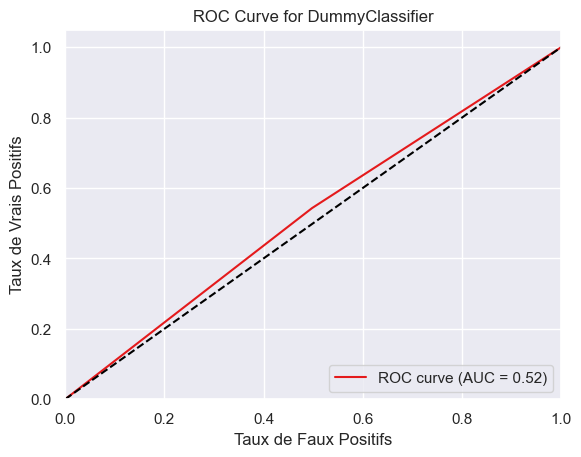

,precision,recall,f1-score,support
0.0,0.925636,0.502123,0.651067,5652.000000
1.0,0.087844,0.543086,0.151228,499.000000
accuracy,0.505446,0.505446,0.505446,0.505446
macro avg,0.506740,0.522605,0.401147,6151.000000
weighted avg,0.857670,0.505446,0.610517,6151.000000


F-beta score (beta=2) = 0.26667978744341664
Cross-validated F-beta score (beta=2): 0.24733289454799098
Temps d'exécution pour DummyClassifier : 6.72 secondes


In [59]:
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_name = 'DummyClassifier'
dummy_auc, dummy_accuracy, dummy_fbeta, dummy_report, dummy_duration = train_and_log_model(dummy_model, dummy_name, data)

## Logistic Regression

2024/10/21 00:37:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model LogisticRegression saved as models/LogisticRegression_pipeline.pkl
Matrice de confusion pour LogisticRegression :
TN (True Negatives): 4061
FP (False Positives): 1591
FN (False Negatives): 206
TP (True Positives): 293


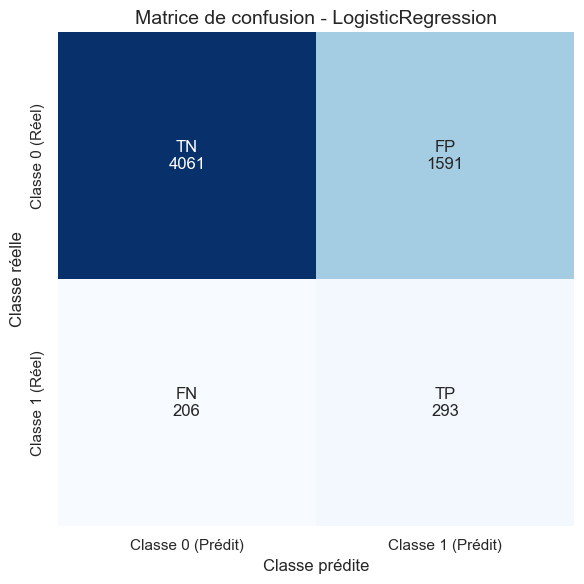

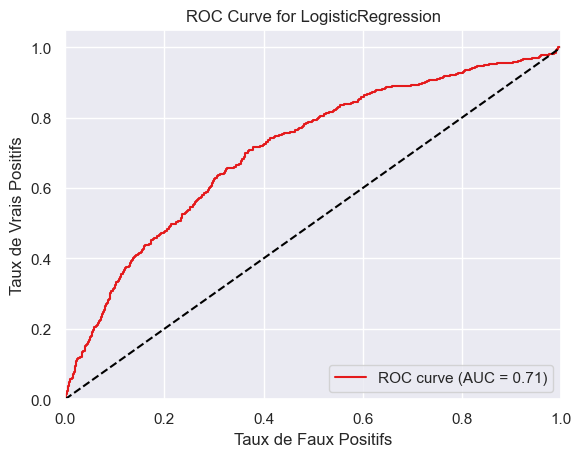

,precision,recall,f1-score,support
0.0,0.951723,0.718507,0.818833,5652.000000
1.0,0.155520,0.587174,0.245909,499.000000
accuracy,0.707852,0.707852,0.707852,0.707852
macro avg,0.553621,0.652841,0.532371,6151.000000
weighted avg,0.887131,0.707852,0.772354,6151.000000


F-beta score (beta=2) = 0.37757731958762886
Cross-validated F-beta score (beta=2): 0.38894806760741996
Temps d'exécution pour LogisticRegression : 86.27 secondes


In [60]:
# Logistic Regression
logistic_model = LogisticRegression(solver='liblinear', random_state=42)
logistic_name = 'LogisticRegression'
logistic_auc, logistic_accuracy, logistic_fbeta, logistic_report, logistic_duration = train_and_log_model(logistic_model, logistic_name, data)

## Random Forest

2024/10/21 00:38:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model RandomForest saved as models/RandomForest_pipeline.pkl
Matrice de confusion pour RandomForest :
TN (True Negatives): 5596
FP (False Positives): 56
FN (False Negatives): 478
TP (True Positives): 21


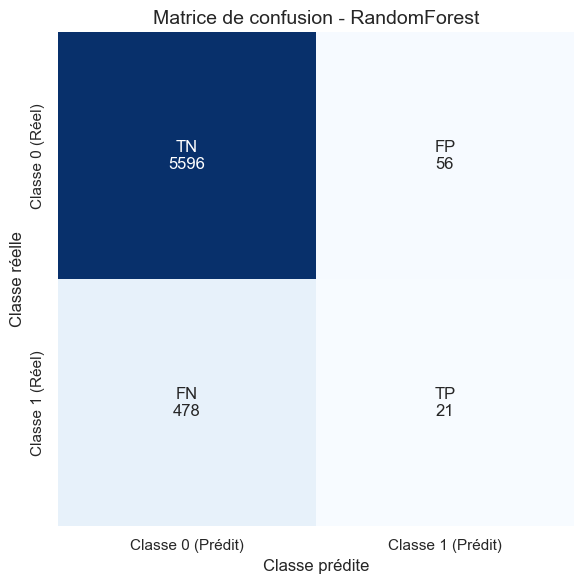

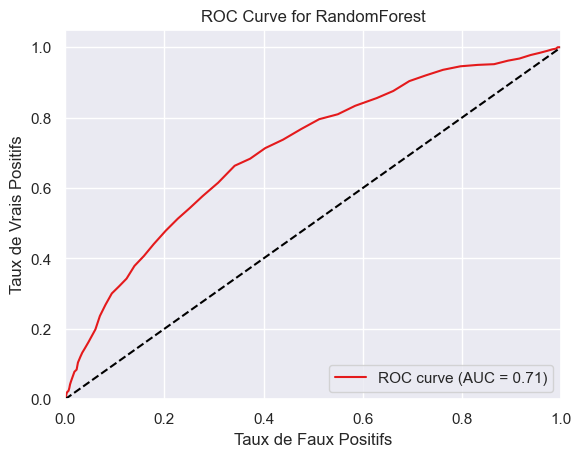

,precision,recall,f1-score,support
0.0,0.921304,0.990092,0.954460,5652.000000
1.0,0.272727,0.042084,0.072917,499.000000
accuracy,0.913185,0.913185,0.913185,0.913185
macro avg,0.597016,0.516088,0.513688,6151.000000
weighted avg,0.868688,0.913185,0.882945,6151.000000


F-beta score (beta=2) = 0.05065123010130246
Cross-validated F-beta score (beta=2): 0.0638049273536387
Temps d'exécution pour RandomForest : 69.68 secondes


In [61]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_name = 'RandomForest'
rf_auc, rf_accuracy, rf_fbeta, rf_report, rf_duration = train_and_log_model(rf_model, rf_name, data)

## XGBoost

2024/10/21 00:39:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model XGBoost saved as models/XGBoost_pipeline.pkl
Matrice de confusion pour XGBoost :
TN (True Negatives): 5452
FP (False Positives): 200
FN (False Negatives): 424
TP (True Positives): 75


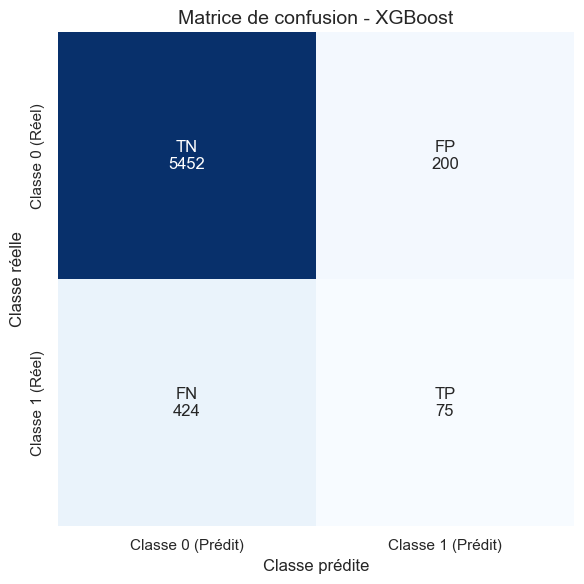

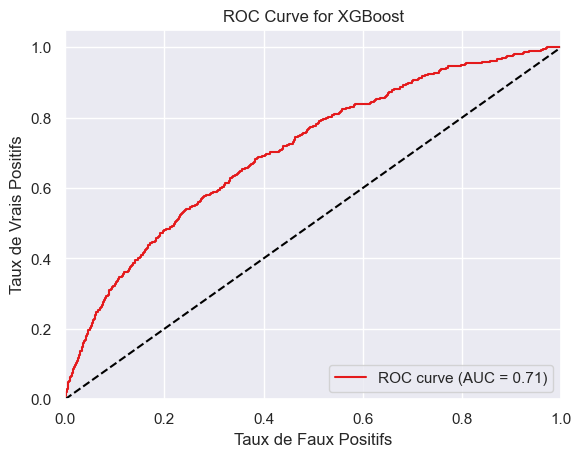

,precision,recall,f1-score,support
0.0,0.927842,0.964614,0.945871,5652.000000
1.0,0.272727,0.150301,0.193798,499.000000
accuracy,0.898553,0.898553,0.898553,0.898553
macro avg,0.600285,0.557457,0.569835,6151.000000
weighted avg,0.874696,0.898553,0.884859,6151.000000


F-beta score (beta=2) = 0.16512549537648613
Cross-validated F-beta score (beta=2): 0.16582577530930395
Temps d'exécution pour XGBoost : 16.83 secondes


In [62]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_name = 'XGBoost'
xgb_auc, xgb_accuracy, xgb_fbeta, xgb_report, xgb_duration  = train_and_log_model(xgb_model, xgb_name, data)

## Light Gbm

[LightGBM] [Info] Number of positive: 11278, number of negative: 11278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119696
[LightGBM] [Info] Number of data points in the train set: 22556, number of used features: 540
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/10/21 00:39:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model LightGBM saved as models/LightGBM_pipeline.pkl
Matrice de confusion pour LightGBM :
TN (True Negatives): 5529
FP (False Positives): 123
FN (False Negatives): 436
TP (True Positives): 63


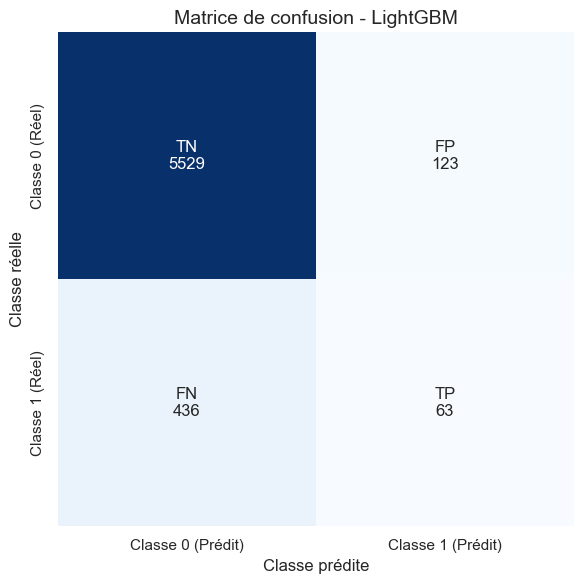

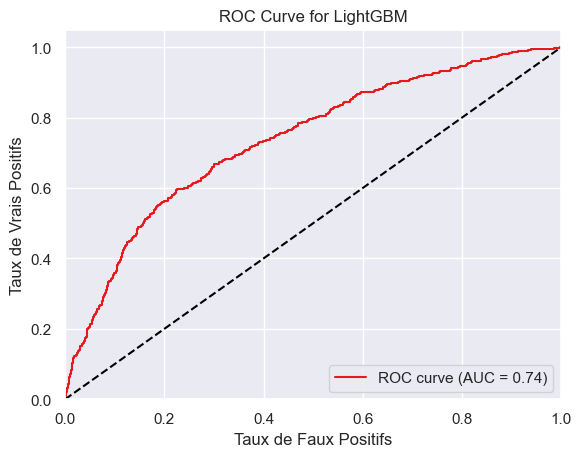

,precision,recall,f1-score,support
0.0,0.926907,0.978238,0.951881,5652.00000
1.0,0.338710,0.126253,0.183942,499.00000
accuracy,0.909120,0.909120,0.909120,0.90912
macro avg,0.632808,0.552245,0.567911,6151.00000
weighted avg,0.879189,0.909120,0.889582,6151.00000


F-beta score (beta=2) = 0.14436296975252064
[LightGBM] [Info] Number of positive: 11283, number of negative: 11283
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119368
[LightGBM] [Info] Number of data points in the train set: 22566, number of used features: 539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 11283, number of negative: 11283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118785
[LightGBM] [Info] Number of data points in the train set: 22566, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGB

In [63]:
# LightGBM
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42)
lgbm_name = 'LightGBM'
lgbm_auc, lgbm_accuracy, lgbm_fbeta, lgbm_report, lgbm_duration = train_and_log_model(lgbm_model, lgbm_name, data)

### Results

In [64]:
# Create results dataframe
res_df = pd.DataFrame({
    'Model': ['Dummy', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM'],
    'F-beta score': [dummy_fbeta, logistic_fbeta, rf_fbeta,  xgb_fbeta, lgbm_fbeta],
    'AUC score': [dummy_auc, logistic_auc, rf_auc, xgb_auc,lgbm_auc],
    'Accuracy': [dummy_report.loc['accuracy', 'precision'],
                 logistic_report.loc['accuracy', 'precision'],
                 rf_report.loc['accuracy', 'precision'],
                 xgb_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision']],
    'Precision': [dummy_report.loc['macro avg', 'precision'],
                 logistic_report.loc['macro avg', 'precision'],
                 rf_report.loc['macro avg', 'precision'],
                  xgb_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision']],
    'Recall': [dummy_report.loc['macro avg', 'recall'],
               logistic_report.loc['macro avg', 'recall'],
               rf_report.loc['macro avg', 'recall'],
               xgb_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall']],
    'F1-score': [dummy_report.loc['macro avg', 'f1-score'],
                 logistic_report.loc['macro avg', 'f1-score'],
                 rf_report.loc['macro avg', 'f1-score'],
                 xgb_report.loc['macro avg', 'f1-score'],
                 lgbm_report.loc['macro avg', 'f1-score']],
        'duration': [dummy_duration, logistic_duration, rf_duration,  xgb_duration, lgbm_duration],
})

display(res_df)

,Model,F-beta score,AUC score,Accuracy,Precision,Recall,F1-score,duration
0,Dummy,0.266680,0.522605,0.505446,0.506740,0.522605,0.401147,6.717771
1,LogisticRegression,0.377577,0.709374,0.707852,0.553621,0.652841,0.532371,86.270875
2,RandomForest,0.050651,0.706061,0.913185,0.597016,0.516088,0.513688,69.683576
3,XGBoost,0.165125,0.705975,0.898553,0.600285,0.557457,0.569835,16.830931
4,LightGBM,0.144363,0.736317,0.909120,0.632808,0.552245,0.567911,24.700677


In [70]:
# Un F-beta score (beta=2) = 0.2491 signifie que le modèle a une performance relativement faible, surtout lorsqu'on privilégie le rappel (la capacité à identifier les vrais positifs).
# Cela peut indiquer que le modèle n'identifie pas bien les cas positifs ou fait trop d'erreurs de faux négatifs (c'est-à-dire, ne détecte pas correctement ceux qui devraient être identifiés comme positifs).

**The best model regarding our business score is the XGBoost model.**
<br>I decide to select this model for the project. 

Let's tune its hyperparameters.

# two-step process for optimizing XGBoost best model

## Hyperparametrization

In [71]:
# XGBoost hyperparameter optimisation avec hyperopt

In [72]:
#Hyperopt : Remplace GridSearchCV pour une exploration plus flexible et potentiellement plus rapide de l'espace des hyperparamètre

In [73]:
"""espace de recherche pour les hyperparamètres importants comme :

max_depth : La profondeur maximale des arbres de décision.
subsample : Fraction des données d'entraînement à utiliser pour chaque arbre.
colsample_bytree : Fraction des colonnes à échantillonner pour chaque arbre.
learning_rate : Taux d'apprentissage.
min_child_weight : Critère de régularisation (influence la complexité de l'arbre).
n_estimators : Nombre d'arbres dans le modèle."""


"espace de recherche pour les hyperparamètres importants comme :\n\nmax_depth : La profondeur maximale des arbres de décision.\nsubsample : Fraction des données d'entraînement à utiliser pour chaque arbre.\ncolsample_bytree : Fraction des colonnes à échantillonner pour chaque arbre.\nlearning_rate : Taux d'apprentissage.\nmin_child_weight : Critère de régularisation (influence la complexité de l'arbre).\nn_estimators : Nombre d'arbres dans le modèle."

In [74]:
def check_label_encoding(y_train, y_test):
    # Importing the numpy library to manipulate label data
    import numpy as np

    # Obtain the unique values in the training and testing label sets
    unique_train = np.unique(y_train)
    unique_test = np.unique(y_test)

    # Determine the expected range of unique values, should be [0, n-1] based on the number of unique values
    expected_train_range = np.arange(len(unique_train))
    expected_test_range = np.arange(len(unique_test))

    # Compare the sets of unique values to the expected ranges to see if they match exactly
    correctly_encoded_train = np.array_equal(unique_train, expected_train_range)
    correctly_encoded_test = np.array_equal(unique_test, expected_test_range)

    # Print out whether the train and test labels are correctly encoded along with their unique values
    print("Train labels are correctly encoded:", correctly_encoded_train)
    print("Unique values in train labels:", unique_train)
    print("Test labels are correctly encoded:", correctly_encoded_test)
    print("Unique values in test labels:", unique_test)

# Call the function with y_train and y_test to check the label encoding
check_label_encoding(y_train, y_test)

Train labels are correctly encoded: True
Unique values in train labels: [0. 1.]
Test labels are correctly encoded: True
Unique values in test labels: [0. 1.]


In [75]:
"""import os
import mlflow
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score
import xgboost as xgb
import joblib
import numpy as np

def optimize_xgb_hyperopt(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=50):
    model_dir = "../models"
    os.makedirs(model_dir, exist_ok=True)
    
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)
    
    # Pipeline for preprocessing
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Fit and transform training data, and transform testing data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Oversampling and undersampling applied only to training data
    sampler = ImbPipeline([
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state))
    ])
    
    x_train_resampled, y_train_resampled = sampler.fit_resample(x_train_prepared, y_train)

    # Define the hyperparameter space
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    # Objective function for Hyperopt
    def objective(params):
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
        return {'loss': -score, 'status': STATUS_OK}

    # Execute optimization
    trials = Trials()
    best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    
    # Extract the best model parameters
    best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
    best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
    best_model.fit(x_train_resampled, y_train_resampled)
    
    y_pred = best_model.predict(x_test_prepared)
    final_fbeta = fbeta_score(y_test, y_pred, beta=beta)

    # Save the model
    model_path = f"../models/{target_name}_xgb_hyperopt_tuned.pkl"
    joblib.dump(best_model, model_path)
    mlflow.log_artifact(model_path)
    
    # Log final metrics
    mlflow.log_metric("final_fbeta", final_fbeta)
    
    return x_test_prepared, y_test, y_pred, final_fbeta, best_params

# Use the function
x_test_prepared, y_test, y_pred, final_fbeta, best_hyperparams = optimize_xgb_hyperopt(data)
print(f"Final F-beta score: {final_fbeta}")"""


'import os\nimport mlflow\nfrom hyperopt import hp, fmin, tpe, Trials, STATUS_OK\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import Pipeline\nfrom imblearn.pipeline import Pipeline as ImbPipeline\nfrom imblearn.over_sampling import SMOTE\nfrom imblearn.under_sampling import RandomUnderSampler\nfrom sklearn.metrics import make_scorer, fbeta_score\nimport xgboost as xgb\nimport joblib\nimport numpy as np\n\ndef optimize_xgb_hyperopt(data, target_name=\'TARGET\', train_size=0.8, random_state=42, beta=2, max_evals=50):\n    model_dir = "../models"\n    os.makedirs(model_dir, exist_ok=True)\n    \n    target = data[target_name].to_numpy()\n    features = data.drop(columns=[target_name]).to_numpy()\n    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)\n    \n    # Pipeline for prepr

In [76]:
"""
# Calculating the improvement
improvement = (final_fbeta - xgb_fbeta) / xgb_fbeta if xgb_fbeta else 0
print(f"\nImprovement in F-beta score: {improvement:.2%}")"""


'\n# Calculating the improvement\nimprovement = (final_fbeta - xgb_fbeta) / xgb_fbeta if xgb_fbeta else 0\nprint(f"\nImprovement in F-beta score: {improvement:.2%}")'

In [77]:
mlflow.end_run()

## Comparison before/after hyperparametrization

In [81]:
import os
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score, classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import joblib
import numpy as np

# Function to optimize and compare models
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10):
    # Separate the target variable from features
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    
    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Define a preprocessing pipeline
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
        ('scaler', StandardScaler()),  # Standardize features
    ])
    
    # Prepare training and testing data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Apply resampling only on training data to handle class imbalance
    sampler = ImbPipeline([
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state))
    ])
    
    # Resample the training data
    x_train_resampled, y_train_resampled = sampler.fit_resample(x_train_prepared, y_train)

    # Define the hyperparameter space for XGBoost
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    # Define the objective function for Hyperopt optimization
    def objective(params):
        # Instantiate an XGBoost classifier with given parameters
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        # Define the scorer using F-beta metric
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)
        # Perform cross-validation and calculate the mean score
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
        # Return the negative score as loss for minimization
        return {'loss': -score, 'status': STATUS_OK}

    try:
        # Start an MLflow run
        mlflow.start_run()
        trials = Trials()
        # Perform hyperparameter optimization
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Train the optimized model with the best hyperparameters
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Evaluate the optimized model by predicting probabilities
        y_pred_proba_optimized = best_model.predict_proba(x_test_prepared)[:, 1]
        # Convert probabilities to binary predictions
        y_pred_optimized = (y_pred_proba_optimized >= 0.5).astype(int)
        # Calculate F-beta score
        final_fbeta_optimized = fbeta_score(y_test, y_pred_optimized, beta=beta)
        # Generate a classification report
        clf_report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)

        # Save the optimized model
        model_path = f"../models/{target_name}_xgb_hyperopt_tuned.pkl"
        joblib.dump(best_model, model_path)
        # Log the model and metric in MLflow
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta_optimized", final_fbeta_optimized)

        print(f"Optimized model F-beta (beta={beta}): {final_fbeta_optimized}")
    
    finally:
        # End the MLflow run
        mlflow.end_run()

    # Compare with a non-optimized model
    non_optimized_model = xgb.XGBClassifier(random_state=random_state, eval_metric='logloss')
    non_optimized_model.fit(x_train_resampled, y_train_resampled)

    # Predict and evaluate the non-optimized model
    y_pred_proba_non_optimized = non_optimized_model.predict_proba(x_test_prepared)[:, 1]
    y_pred_non_optimized = (y_pred_proba_non_optimized >= 0.5).astype(int)
    final_fbeta_non_optimized = fbeta_score(y_test, y_pred_non_optimized, beta=beta)
    clf_report_non_optimized = classification_report(y_test, y_pred_non_optimized, output_dict=True)

    print(f"Non-optimized model F-beta (beta={beta}): {final_fbeta_non_optimized}")

    return (best_model, final_fbeta_optimized, best_params, clf_report_optimized, y_pred_proba_optimized,
            final_fbeta_non_optimized, clf_report_non_optimized, y_pred_proba_non_optimized, y_test)

# Call the function and compare models
(best_model, final_fbeta_optimized, best_hyperparams, clf_report_optimized, y_pred_proba_optimized,
 final_fbeta_non_optimized, clf_report_non_optimized, y_pred_proba_non_optimized, y_test) = optimize_xgb(data)

# Display the classification reports for both models
print("=== Optimized Model Classification Report ===")
display(clf_report_optimized)
print("\n=== Non-Optimized Model Classification Report ===")
display(clf_report_non_optimized)

100%|██████████| 10/10 [02:15<00:00, 13.51s/trial, best loss: -0.8179010976630756]


/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Optimized model F-beta (beta=2): 0.30624769853933964
Non-optimized model F-beta (beta=2): 0.15251989389920426
=== Optimized Model Classification Report ===


{'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5652.0},
 '1.0': {'precision': 0.08112502032189887,
  'recall': 1.0,
  'f1-score': 0.1500751879699248,
  'support': 499.0},
 'accuracy': 0.08112502032189887,
 'macro avg': {'precision': 0.04056251016094944,
  'recall': 0.5,
  'f1-score': 0.0750375939849624,
  'support': 6151.0},
 'weighted avg': {'precision': 0.006581268922228506,
  'recall': 0.08112502032189887,
  'f1-score': 0.012174852673872945,
  'support': 6151.0}}


=== Non-Optimized Model Classification Report ===


{'0.0': {'precision': 0.9269328802039083,
  'recall': 0.9651450813871196,
  'f1-score': 0.9456531160613678,
  'support': 5652.0},
 '1.0': {'precision': 0.2593984962406015,
  'recall': 0.13827655310621242,
  'f1-score': 0.1803921568627451,
  'support': 499.0},
 'accuracy': 0.8980653552267924,
 'macro avg': {'precision': 0.5931656882222549,
  'recall': 0.551710817246666,
  'f1-score': 0.5630226364620564,
  'support': 6151.0},
 'weighted avg': {'precision': 0.8727791397393188,
  'recall': 0.8980653552267924,
  'f1-score': 0.8835713051948237,
  'support': 6151.0}}

## Custom threshold

""

Dans le contexte des modèles de classification, le seuil (ou threshold) par défaut pour décider si une prédiction est de la classe positive ou négative est généralement de 0.5. Cela signifie que si la probabilité prédite est supérieure ou égale à 0.5, alors la prédiction appartient à la classe positive ; sinon, elle appartient à la classe négative.

Cependant, dans certaines applications, il peut être bénéfique de modifier ce seuil afin de mieux équilibrer les métriques de performance telles que le rappel, la précision, la F-mesure, et surtout dans des cas où l'un des types d'erreur (faux positif ou faux négatif) est plus coûteux.

En ajustant le seuil, il est possible de contrôler le compromis entre la précision et le rappel du modèle, et ainsi d'améliorer le score de performance global selon les besoins du problème traité. Cela permet de personnaliser le modèle aux exigences spécifiques liées aux faux négatifs."""

In [84]:
import numpy as np
from sklearn.metrics import fbeta_score, precision_recall_curve

In [85]:
def find_best_threshold(y_true, y_pred_proba, beta=2):
    # Calcul des scores de précision, de rappel et des seuils associés
    # Ces scores sont calculés pour différents seuils de classification
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    
    fbeta_scores = []  # Liste pour stocker les scores F-beta calculés
    
    # Boucle sur chaque paire de précision et de rappel
    for prec, rec in zip(precision, recall):
        # Prévenir la division par zéro si la précision et le rappel sont tous deux zéro
        if prec + rec == 0:
            fbeta_scores.append(0)
        else:
            # Calcul du score F-beta en utilisant la formule
            score = (1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec)
            fbeta_scores.append(score)
    
    # Trouver l'indice du meilleur score F-beta
    best_idx = np.nanargmax(fbeta_scores)  # Utilisation de nanargmax pour gérer les possibles NaNs
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 1.0  # Sécurité en cas d'indice hors limite
    best_score = fbeta_scores[best_idx]
    
    return best_threshold, best_score

In [86]:
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10):
    # Define the directory where models will be saved
    model_dir = "../models"
    # Create the directory if it does not exist
    os.makedirs(model_dir, exist_ok=True)
    
    # Separate the target variable from features
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Create a preprocessing pipeline for data
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
        ('scaler', StandardScaler()),                 # Standardize features
    ])
    
    # Apply preprocessing to the train and test data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Create a pipeline for data resampling to handle imbalance
    sampler = ImbPipeline([
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state))
    ])
    
    # Resample training data to balance classes
    x_train_resampled, y_train_resampled = sampler.fit_resample(x_train_prepared, y_train)

    # Define the hyperparameter search space for the XGBoost model
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    try:
        # Start a new MLFlow run to log experiment
        mlflow.start_run()
        # Define objective function for hyperparameter optimization
        def objective(params):
            # Create XGBoost classifier with given parameters
            model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
            # Define F-beta scorer for evaluation
            fbeta_scorer = make_scorer(fbeta_score, beta=beta)
            # Perform cross-validation and calculate mean F-beta score
            score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
            return {'loss': -score, 'status': STATUS_OK}  # Return negative score for minimization

        # Initialize trials object to track search
        trials = Trials()
        # Run hyperparameter optimization using Tree-structured Parzen Estimator (TPE)
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        # Extract best parameters from trials
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Train the best model with resampled training data
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Generate prediction probabilities for class 1 on test data
        y_pred_proba = best_model.predict_proba(x_test_prepared)[:, 1]
        # Calculate precision, recall, and thresholds for PR curve
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        # Calculate F-beta scores at each threshold
        fbeta_scores = [(1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec) if (prec + rec) != 0 else 0 for prec, rec in zip(precision, recall)]
        # Find the threshold with the highest F-beta score
        best_idx = np.argmax(fbeta_scores)
        best_threshold = thresholds[best_idx]

        # Save the best model to disk
        model_path = f"../models/{target_name}_xgb_hyperopt_tuned.pkl"
        joblib.dump(best_model, model_path)
        # Log the model and the final F-beta score to MLFlow
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta", fbeta_scores[best_idx] if not np.isnan(fbeta_scores[best_idx]) else 0)
    finally:
        # Ensure that the run is ended
        mlflow.end_run()

    # Return the best model, best F-beta score, best hyperparameters, and best threshold
    return best_model, fbeta_scores[best_idx], best_params, best_threshold

# Driver code to demonstrate the function usage
best_model, final_fbeta, best_hyperparams, best_threshold = optimize_xgb(data)
print(f"Best Threshold: {best_threshold}, Final F-beta Score: {final_fbeta}")

100%|██████████| 10/10 [02:29<00:00, 14.92s/trial, best loss: -0.8175499062638707]
Best Threshold: 0.5, Final F-beta Score: 0.30624769853933964


Interprétation des Résultats
Seuil Optimal (Best Threshold)
Le seuil optimal de 0.4726294279098511 indique la probabilité à partir de laquelle les prédictions doivent être classées comme positives (par exemple, si la classe positive est 1). Cela signifie que si la probabilité prédite est supérieure ou égale à 0.4726, la prédiction doit être considérée comme 1 (ou positive), et si elle est inférieure, comme 0 (ou négative).

Score F-beta (Best F-beta Score)
Le score F-beta de 0.3724648985959438 est une mesure qui combine la précision et le rappel de la prédiction, en donnant plus d'importance au rappel si beta est supérieur à 1. Un beta de 2, comme utilisé ici, signifie que vous valorisez le rappel deux fois plus que la précision. Ce score peut être interprété comme suit :

Un score F-beta de 0.3725 est modérément faible, suggérant que le modèle a une efficacité limitée pour identifier correctement les vrais positifs (en tenant compte de l'importance accrue du rappel). Cela pourrait être dû à un nombre insuffisant de vrais positifs correctement identifiés ou à un trop grand nombre de faux négatifs, particulièrement critique quand le rappel est valorisé.

### Fonction pour calculer et afficher la courbe ROC avec le seuil optimal :

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, fbeta_score

def compute_roc_curve_with_best_threshold(y_test, y_pred_proba, model_name="Model"):
    # Calculate metrics for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Determine the best threshold based on the point closest to the top-left corner - Distance to the perfect point (0,1)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Display the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line of no-discrimination
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red')  # Mark the best threshold
    plt.text(fpr[optimal_idx], tpr[optimal_idx], f'Best Threshold = {optimal_threshold:.2f}', fontsize=12, ha='right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    # Explanatory text on ROC curve interpretation
    print("The ROC curve illustrates the model's ability to discriminate between positive and negative classes at different thresholds. "
          "The AUC (Area Under Curve) measures the entirety of the ROC curve; a value close to 1 indicates high model performance, "
          "while a value close to 0.5 suggests a lack of discriminatory ability. "
          "The optimal threshold, marked on the curve, maximizes the difference between true positive and false positive rates, "
          "thus offering a trade-off between sensitivity and specificity.")

    return auc, optimal_threshold

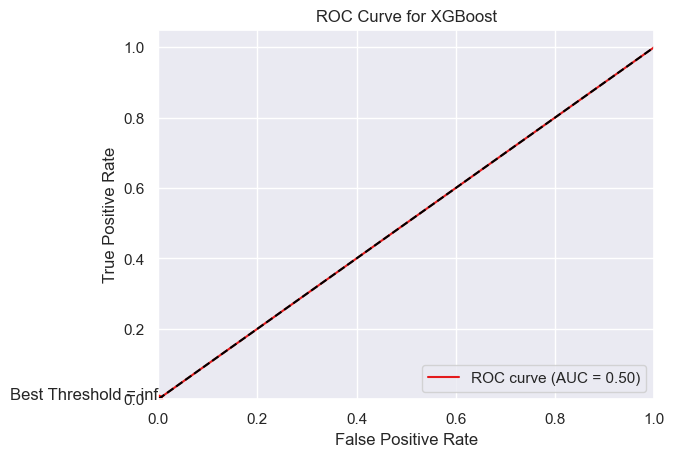

La courbe ROC illustre la capacité du modèle à discriminer entre les classes positives et négatives à différents seuils. L'AUC (Area Under Curve) mesure l'intégralité de la courbe ROC; une valeur proche de 1 indique une performance élevée du modèle, tandis qu'une valeur proche de 0.5 suggère une absence de capacité discriminatoire. Le seuil optimal, marqué sur la courbe, maximise la différence entre les taux de vrais positifs et de faux positifs, offrant ainsi un compromis entre sensibilité et spécificité.
Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5652
         1.0       0.00      0.00      0.00       499

    accuracy                           0.92      6151
   macro avg       0.46      0.50      0.48      6151
weighted avg       0.84      0.92      0.88      6151

F-beta score (beta=2) at Optimal Threshold: 0.0
Optimal Threshold: inf
Confusion Matrix at Optimal Threshold:
[[5652 

/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [88]:
# Calculate the prediction probabilities using the optimized prediction values
# Alternatively, use non-optimized probabilities for comparison
y_pred_proba = y_pred_proba_optimized 

# Display the ROC curve and calculate the optimal threshold for classification
gfg_score, optimal_threshold = compute_roc_curve_with_best_threshold(y_test, y_pred_proba, model_name='XGBoost')

# Use the optimal threshold to make class predictions
xgbc_pred_optimal = y_pred_proba >= optimal_threshold

# Calculate and display the classification report based on the optimal threshold
print("Classification Report at Optimal Threshold:")
print(classification_report(y_test, xgbc_pred_optimal))

# Calculate the F-beta score, which is a weighted measure of precision and recall
fbeta = fbeta_score(y_test, xgbc_pred_optimal, beta=2)
print(f"F-beta score (beta=2) at Optimal Threshold: {fbeta}")
print(f"Optimal Threshold: {optimal_threshold}")

# Display the confusion matrix to visualize the performance of the classification at the optimal threshold
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, xgbc_pred_optimal)
print("Confusion Matrix at Optimal Threshold:")
print(cm)

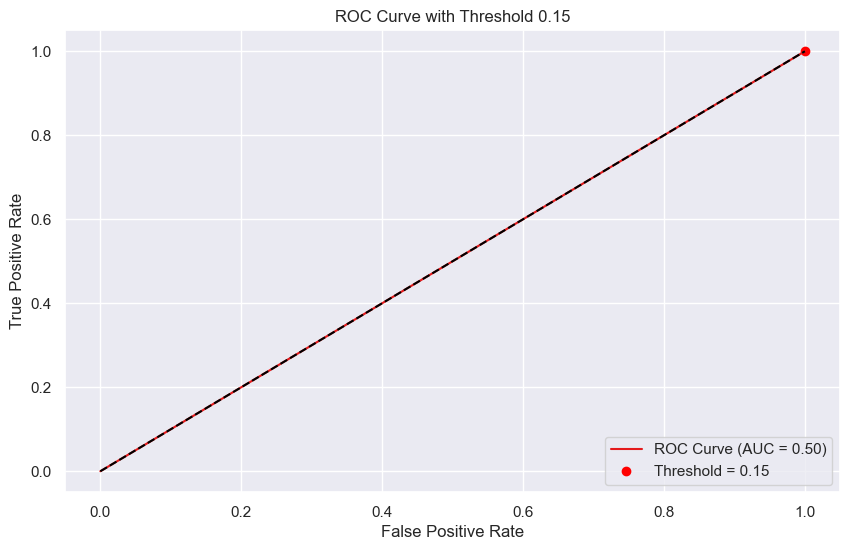


=== Résultats pour le seuil = 0.15 ===
Matrice de confusion pour Threshold = 0.15 :
TN (True Negatives): 0
FP (False Positives): 5652
FN (False Negatives): 0
TP (True Positives): 499


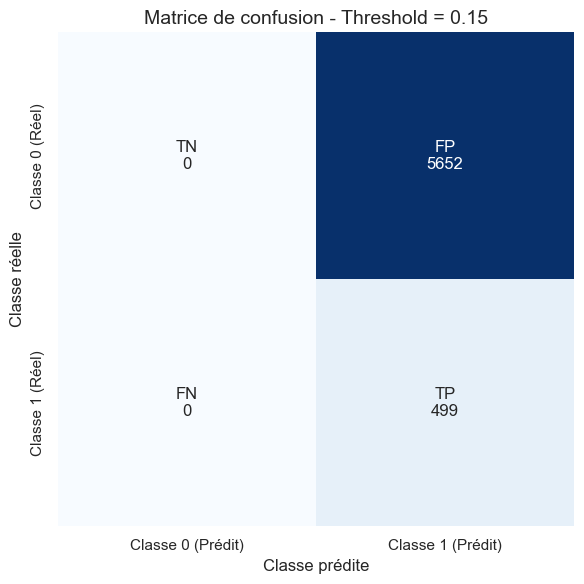

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5652
         1.0       0.08      1.00      0.15       499

    accuracy                           0.08      6151
   macro avg       0.04      0.50      0.08      6151
weighted avg       0.01      0.08      0.01      6151

F-beta Score (beta=2) = 0.3062


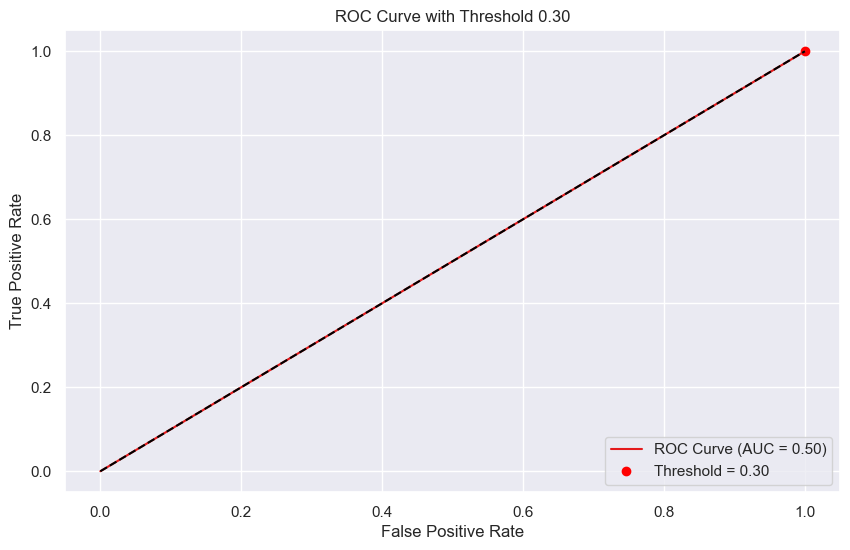


=== Résultats pour le seuil = 0.30 ===
Matrice de confusion pour Threshold = 0.30 :
TN (True Negatives): 0
FP (False Positives): 5652
FN (False Negatives): 0
TP (True Positives): 499


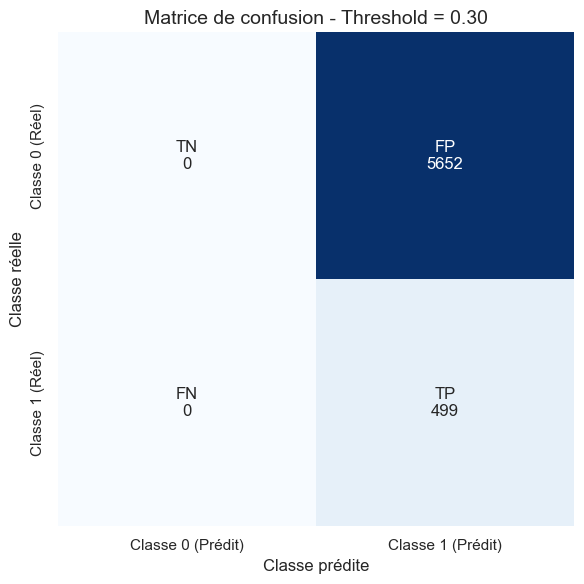

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5652
         1.0       0.08      1.00      0.15       499

    accuracy                           0.08      6151
   macro avg       0.04      0.50      0.08      6151
weighted avg       0.01      0.08      0.01      6151

F-beta Score (beta=2) = 0.3062


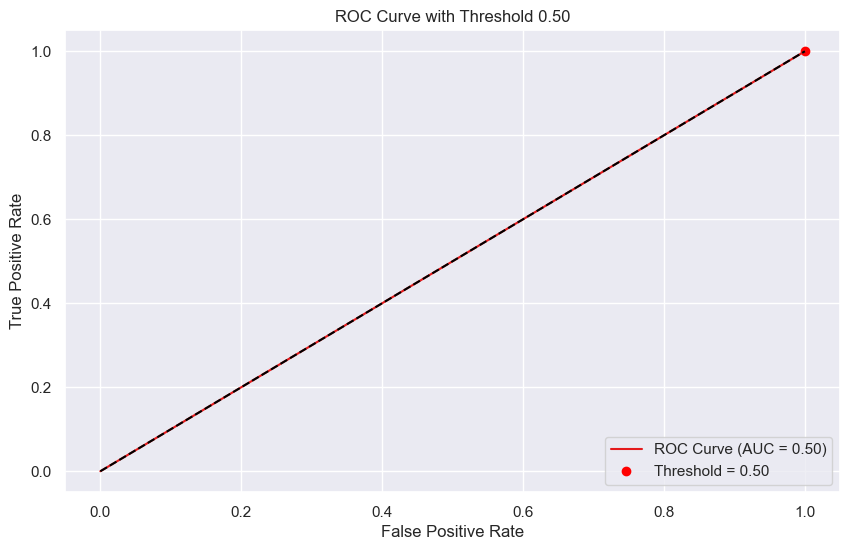


=== Résultats pour le seuil = 0.50 ===
Matrice de confusion pour Threshold = 0.50 :
TN (True Negatives): 0
FP (False Positives): 5652
FN (False Negatives): 0
TP (True Positives): 499


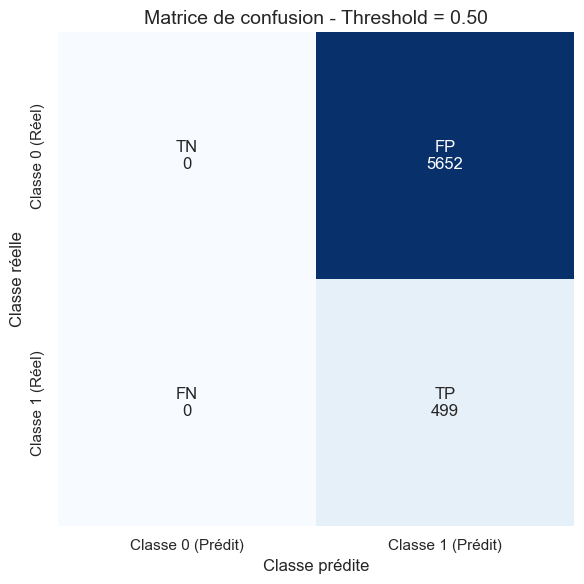

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5652
         1.0       0.08      1.00      0.15       499

    accuracy                           0.08      6151
   macro avg       0.04      0.50      0.08      6151
weighted avg       0.01      0.08      0.01      6151

F-beta Score (beta=2) = 0.3062


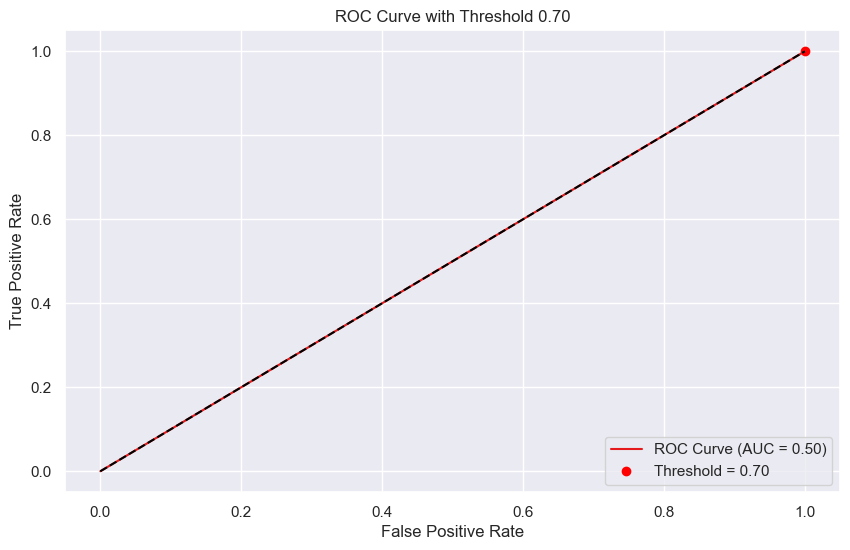


=== Résultats pour le seuil = 0.70 ===
Matrice de confusion pour Threshold = 0.70 :
TN (True Negatives): 5652
FP (False Positives): 0
FN (False Negatives): 499
TP (True Positives): 0


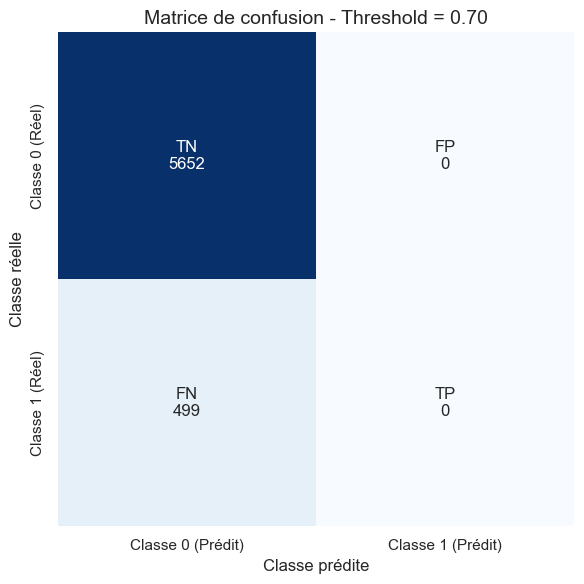

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5652
         1.0       0.00      0.00      0.00       499

    accuracy                           0.92      6151
   macro avg       0.46      0.50      0.48      6151
weighted avg       0.84      0.92      0.88      6151

F-beta Score (beta=2) = 0.0000


In [89]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, fbeta_score

# Function to plot ROC curve and display confusion matrices for multiple thresholds

def plot_roc_curve_and_confusion_matrices(y_test, y_pred_proba, thresholds=[0.15, 0.3, 0.5, 0.7], beta=2):
    """
    Displays a ROC curve and confusion matrix for each threshold provided.

    Parameters:
    - y_test: true class labels.
    - y_pred_proba: predicted probabilities of the positive class.
    - thresholds: list of threshold values to evaluate.
    - beta: beta value for calculating the F-beta score.
    """
    # Compute ROC curve metrics such as false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    # Calculate Area Under the Curve (AUC) score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Iterate over each threshold to plot ROC curve with marked point
    for threshold in thresholds:
        plt.figure(figsize=(10, 6))

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line to represent a random model
        
        # Find closest index to the given threshold, to mark it on the ROC curve
        idx = np.argmin(np.abs(roc_thresholds - threshold))
        # Mark the specific threshold on the plot
        plt.scatter(fpr[idx], tpr[idx], marker='o', color='red', label=f'Threshold = {threshold:.2f}')

        # Add labels, title, and legend to the plot
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve with Threshold {threshold:.2f}')
        plt.legend(loc='lower right')

        plt.show()

        # Predict classes using the current threshold
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)

        # Display confusion matrix for the current threshold
        print(f"\n=== Results for Threshold = {threshold:.2f} ===")
        display_confusion_matrix(y_test, y_pred_threshold, model_name=f"Threshold = {threshold:.2f}")

        # Display classification report (precision, recall, f1-score, support)
        report = classification_report(y_test, y_pred_threshold, zero_division=0)
        print("Classification Report:")
        print(report)

        # Calculate and print F-beta score for the given threshold
        fbeta = fbeta_score(y_test, y_pred_threshold, beta=beta, zero_division=0)
        print(f"F-beta Score (beta={beta}) = {fbeta:.4f}")


plot_roc_curve_and_confusion_matrices(y_test, y_pred_proba, thresholds=[0.15, 0.3, 0.5, 0.7], beta=2)

# Best Model including hyperparametization and custom threshold

The revised pipeline handles hyperparameter optimization using Hyperopt, compute the best
threshold for maximizing the F-beta score, and prepare the model for integration into an API that predicts the probability of belonging to class 1 or 0.

In [91]:
import os
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score, classification_report
import xgboost as xgb
import joblib
import numpy as np

# Function to optimize and train the model using XGBoost
# We add a custom threshold to the pipeline so we can retrieve it later
dclass CustomThreshold:
    def __init__(self, model, threshold=0.4650724232196808):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        # Use the model to predict probabilities
        return self.model.predict_proba(X)

    def predict(self, X):
        # Predict binary classes based on the threshold
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def get_threshold(self):
        # Simple getter for the threshold
        return self.threshold

# Main function to optimize and train the XGBoost model
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10, threshold=0.4650724232196808):
    # Extract target and features from data
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    
    # Split the dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Preprocessing pipeline (common for training and prediction)
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Replace missing values
        ('scaler', StandardScaler()),  # Standardize features
    ])
    
    # Transform training and test data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Perform resampling only on training data
    smote = SMOTE(sampling_strategy=0.5, random_state=random_state)  # Apply SMOTE for oversampling
    undersample = RandomUnderSampler(sampling_strategy=1, random_state=random_state)  # Undersample majority class
    
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_prepared, y_train)
    x_train_resampled, y_train_resampled = undersample.fit_resample(x_train_resampled, y_train_resampled)

    # Define hyperparameter space for XGBoost
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),  # Range of tree depths
        'subsample': hp.uniform('subsample', 0.5, 1.0),  # Fraction of samples to be used
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Fraction of columns to be used
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),  # Learning rate
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),  # Number of boosting rounds
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))  # Minimum sum of instance weight
    }

    # Objective function for Hyperopt
    def objective(params):
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)  # Define fbeta scorer
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()  # Perform cross-validation
        return {'loss': -score, 'status': STATUS_OK}

    try:
        mlflow.start_run()

        # Hyperparameter optimization
        trials = Trials()
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Train the optimized model with best hyperparameters
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Create the complete pipeline (resampling removed for prediction)
        full_pipeline = Pipeline(steps=[
            ('preprocessing', preprocess_pipeline),  # Includes imputation and normalization
            ('model', best_model)  # Optimized model
        ])

        # Save the complete pipeline
        model_path = "../models/xgb_pipeline_tuned.pkl"
        joblib.dump(full_pipeline, model_path)

        # Predict probabilities on the test set
        y_pred_proba_optimized = best_model.predict_proba(x_test_prepared)[:, 1]

        # Create binary predictions using the fixed threshold
        y_pred_optimized = (y_pred_proba_optimized >= threshold).astype(int)

        # Calculate F-beta score using the threshold
        final_fbeta_optimized = fbeta_score(y_test, y_pred_optimized, beta=beta)
        clf_report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)

        # Log the model and metrics in MLflow
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta_optimized", final_fbeta_optimized)

        print(f"Optimized model F-beta (beta={beta}, threshold={threshold}): {final_fbeta_optimized}")
    
    finally:
        mlflow.end_run()

    # Return necessary data and explicitly return the best model
    return (full_pipeline, best_model, final_fbeta_optimized, best_params, clf_report_optimized, 
            y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized)


# Call the function with data and retrieve all parameters
(full_pipeline, best_model, final_fbeta_optimized, best_hyperparams, clf_report_optimized, 
 y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized) = optimize_xgb(data)


# Display the results
print("=== Optimized Model Classification Report ===")
print(clf_report_optimized)

100%|██████████| 10/10 [02:47<00:00, 16.74s/trial, best loss: -0.8190037037695153]


/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Optimized model F-beta (beta=2, threshold=0.4650724232196808): 0.30624769853933964
=== Optimized Model Classification Report ===
{'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5652.0}, '1.0': {'precision': 0.08112502032189887, 'recall': 1.0, 'f1-score': 0.1500751879699248, 'support': 499.0}, 'accuracy': 0.08112502032189887, 'macro avg': {'precision': 0.04056251016094944, 'recall': 0.5, 'f1-score': 0.0750375939849624, 'support': 6151.0}, 'weighted avg': {'precision': 0.006581268922228506, 'recall': 0.08112502032189887, 'f1-score': 0.012174852673872945, 'support': 6151.0}}


# Feature importance

LIME et SHAP : 

Les prédictions d’un échantillon sont expliquées à l’aide de LIME, 

et SHAP fournit les contributions de chaque feature pour toutes les observations

## LIME

In [93]:
# Import the LIME library specifically for tabular data
from lime import lime_tabular
# LIME
features_names = data.columns.drop('TARGET')

# Creates a LIME explainer object to interpret the predictions made by the model
lime_explainer = lime_tabular.LimeTabularExplainer(
    x_test_prepared,  # Data on which the model is tested
    mode="classification",  # The task is classification
    class_names=['REPAY SUCCESS', 'REPAY FAILURE'],  # Output class names for better understanding
    feature_names=data.columns.drop('TARGET'),  # Names of the features used in the model
    discretize_continuous=True  # Convert continuous features into discrete bins for analysis
)

# Set the index to a valid position within the x_test data
# Choosing the last index as an example
valid_idx = len(x_test) - 1

# Print the model's predicted class for the selected test instance
print("Prediction : ", best_model.predict(x_test_prepared)[valid_idx])
# Print the actual class label of the selected test instance
print("Actual :     ", y_test[valid_idx])

# Generate an explanation for the model's prediction on a specific instance
explanation = lime_explainer.explain_instance(x_test_prepared[valid_idx], best_model.predict_proba)

# Display the explanation in the Jupyter notebook
display(explanation.show_in_notebook())

# Print the explanation details as a list, showing the contribution of each feature
print(explanation.as_list())

Prediction :  0
Actual :      0.0


[('EXT_SOURCE_2 > 0.80', -0.013077563319938233), ('ORGANIZATION_TYPE_Industry: type 6 <= -0.02', 0.00828793808875499), ('-0.00 < EXT_SOURCE_3 <= 0.68', -0.007876262477004728), ('FLAG_DOCUMENT_15 <= -0.03', 0.00772627111766011), ('ORGANIZATION_TYPE_Trade: type 5 <= -0.01', -0.007720956535185304), ('ORGANIZATION_TYPE_Industry: type 10 <= -0.02', 0.007639057846533085), ('FLAG_DOCUMENT_19 <= -0.02', -0.006805117904139866), ('ORGANIZATION_TYPE_Industry: type 1 <= -0.06', 0.006519955183982409), ('ORGANIZATION_TYPE_Culture <= -0.03', -0.005069608343013519), ('FLAG_DOCUMENT_17 <= -0.01', -0.003003586456044702)]


## SHAP

In [94]:
import shap
import joblib

Comprendre les Modèles Non Linéaires et les Poids des Variables
Modèles Linéaires (comme la régression linéaire ou la régression logistique) :


Les variables ont des coefficients fixes (poids) qui multiplient les valeurs des variables pour produire une prédiction.
Impact Constant : Le poids d'une variable est le même pour toutes les prédictions, donc son impact est constant.
Modèles Non Linéaires (comme les arbres de décision, XGBoost, réseaux de neurones) :


Les relations entre les variables et la prédiction sont complexes et non linéaires.
Pas de Poids Fixes : Les variables n'ont pas de coefficients fixes ; leur impact sur la prédiction dépend des valeurs des autres variables.
Interactions Variables : Les modèles peuvent capturer des interactions complexes entre les variables.

Importance des Variables Variable selon le Client

Contribution Variable :

Dans les modèles non linéaires, la contribution d'une variable à la prédiction peut varier pour chaque client en fonction de ses caractéristiques spécifiques.

Exemple :
Pour un client avec un revenu élevé, la variable "historique de crédit" peut avoir plus d'impact.
Pour un client avec un revenu faible, la variable "revenu" peut être plus déterminante."""

Ce qui est déterminant pour un individu n'est pas nécessairement ce qui l'est pour la population entière.

1. Contribution Locale :
Force Plot : Visualise l'impact de chaque variable sur la prédiction d'un client spécifique.
Waterfall Plot : Montre comment les contributions individuelles des variables s'accumulent pour aboutir à la prédiction finale.

2. Importance Globale :
Summary Plot : Présente l'importance moyenne des variables sur l'ensemble des clients.
Feature Importance Plot : Classe les variables en fonction de leur importance globale.

In [95]:
#vue d'ensemble de l'influence globale des features sur toutes les instances du dataset 

On choisit les variables x_train_prepared et y_test_prepared du modèle les informations SHAP car elles sont calculées sur des données qui reflètent la distribution réelle des données, c'est-à-dire sans suréchantillonnage ou sous-échantillonnage.

# Feature importances

best_model.feature_importances_ calcule l'importance des features en fonction de la fréquence d'utilisation de chaque feature dans les arbres de décision (généralement basé sur le gain ou le poids de chaque feature dans le modèle).

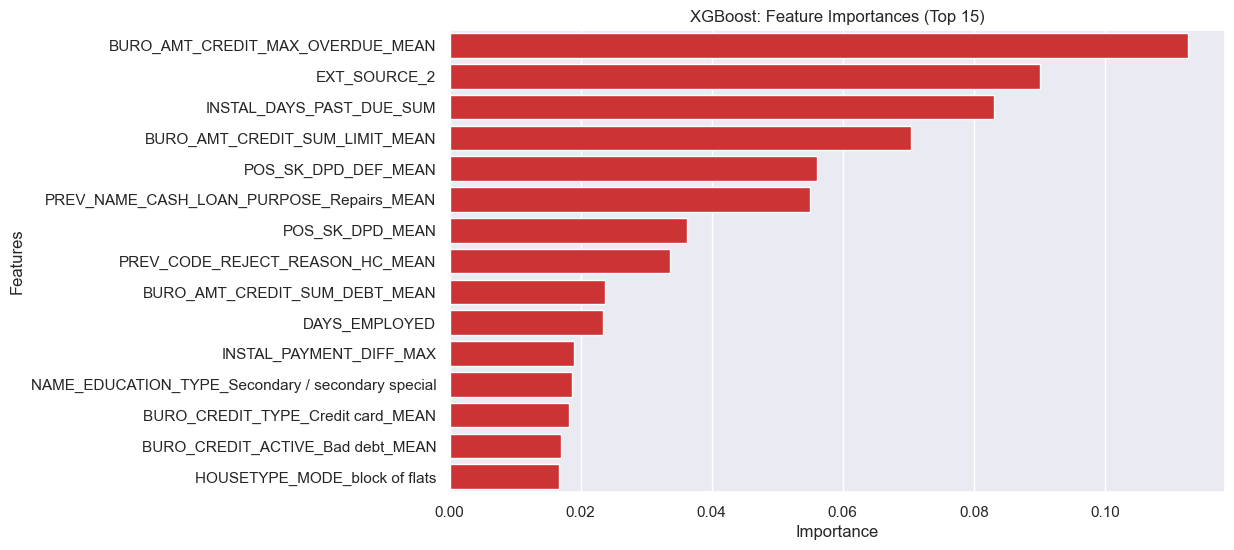

In [96]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that we have the feature names before preprocessing
features_names = data.drop(columns=['TARGET']).columns

# Get the feature importances from the XGBoost model
importances = full_pipeline.named_steps['model'].feature_importances_  # Retrieve the feature importances from XGBoost
sorted_idx = np.argsort(importances)[::-1]  # Sort the indices of importances in descending order

# Limit to the top 15 features
# Extract the indices of the 15 most important features
top_15_idx = sorted_idx[:15]

# Display a bar plot of the feature importances
plt.figure(figsize=(10, 6))
# Create a bar plot with the top 15 feature importances
sns.barplot(x=importances[top_15_idx], y=np.array(features_names)[top_15_idx])
plt.title("XGBoost: Feature Importances (Top 15)")
plt.xlabel('Importance')  # Set the x-axis label
plt.ylabel('Features')  # Set the y-axis label
plt.show()  # Render the plot

### SHAP contribution globale

In [97]:
# Initialiser l'explainer avec le modèle entraîné
explainer = shap.TreeExplainer(best_model)

In [98]:
# Utiliser un échantillon de x_train_prepared comme données de fond
background = x_train_prepared[np.random.choice(x_train_prepared.shape[0], 100, replace=False)]
explainer = shap.TreeExplainer(best_model, data=background)

#### Summary Plot Shap

In [99]:
# Calculer les valeurs SHAP pour les données d'entraînement
shap_values_train = explainer.shap_values(x_train_prepared)
shap_values_test = explainer.shap_values(x_test_prepared)

#### Feature Importance Plot :

/var/folders/t0/bk4v248j27n4pms6k42stgrm0000gn/T/ipykernel_29770/2840200431.py:25: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


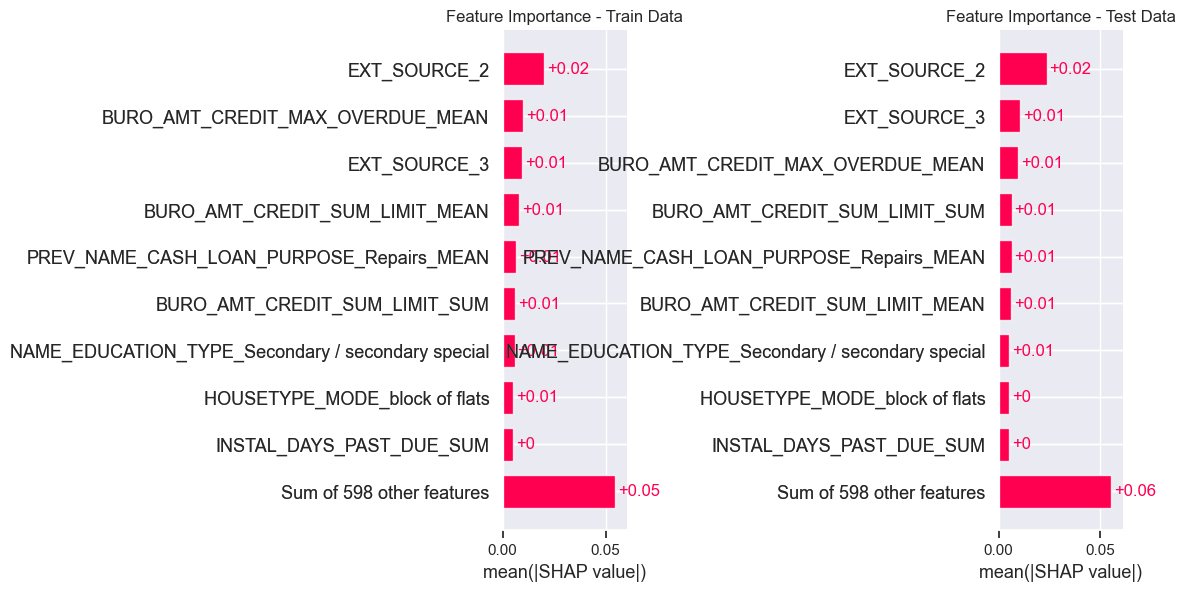

In [100]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer using the trained model and specify the feature names
shap_explainer = shap.Explainer(best_model, x_train_resampled, feature_names=features_names)

# Compute SHAP values for the training data
shap_values_train = shap_explainer(x_train_resampled)
# Compute SHAP values for the test data
shap_values_test = shap_explainer(x_test_prepared)

# Set up a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot a bar chart of feature importance for the training data
plt.sca(axes[0])  # Focus on the first subplot
shap.plots.bar(shap_values_train, show=False)
plt.title('Feature Importance - Train Data')

# Plot a bar chart of feature importance for the test data
plt.sca(axes[1])  # Focus on the second subplot
shap.plots.bar(shap_values_test, show=False)
plt.title('Feature Importance - Test Data')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=3)  # Control the space between the subplots

# Display the figure containing both subplots
plt.show()

#### Shap Beeswarm Plot

In [101]:
# Retrieve features variables
feature_names = data.drop(columns=["TARGET"]).columns.tolist()

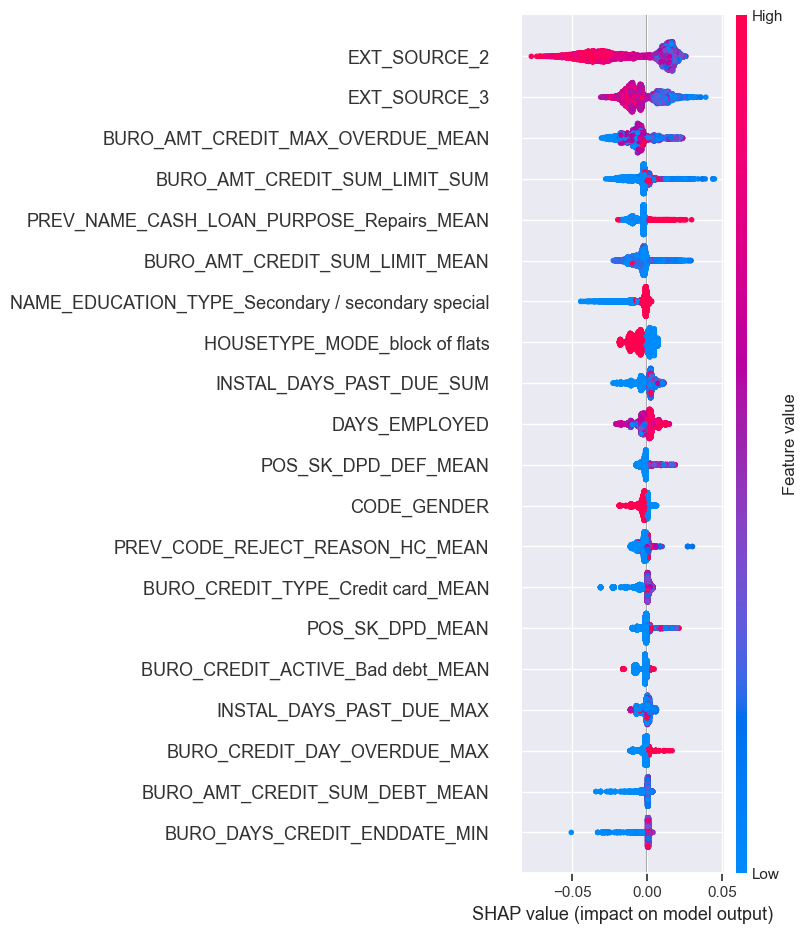

In [102]:
# Beeswarm plot
shap.summary_plot(shap_values_test, x_test_prepared, feature_names=feature_names)

In [103]:
# Initialize the SHAP explainer with the trained model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for both training and test datasets
shap_values_train = explainer.shap_values(x_train_prepared)
shap_values_test = explainer.shap_values(x_test_prepared)

# Check the type of the SHAP values calculated for the training set
# This helps us determine how to handle the shap_values_train object
print("Type of shap_values_train:", type(shap_values_train))
print("Is shap_values_train a list?", isinstance(shap_values_train, list))

# If the SHAP values are returned as a list, select the values for class 1 (positive class)
if isinstance(shap_values_train, list):
    shap_values_train = shap_values_train[1]  # Use values related to the positive class
    shap_values_test = shap_values_test[1]  # Also get the positive class values for the test set
    print("Selected SHAP values for class 1")
else:
    print("Using SHAP values as is")  # No need to adjust for class specific values

# Calculate the mean absolute values of SHAP values to determine feature importance
importances_train = np.abs(shap_values_train).mean(axis=0)
importances_test = np.abs(shap_values_test).mean(axis=0)

# Create a DataFrame to compare feature importances in training and test sets
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Train': importances_train,
    'Importance_Test': importances_test
})

# Calculate the difference in importances between test and training sets
importance_df['Difference'] = importance_df['Importance_Test'] - importance_df['Importance_Train']

# Sort the features based on the calculated difference in importances
importance_df = importance_df.sort_values(by='Difference', ascending=False)

# Display the DataFrame to view the results
# This will show which features' importance varies significantly between training and test sets
display(importance_df)

Type of shap_values_train: <class 'numpy.ndarray'>
Is shap_values_train a list? False
Using SHAP values as is


,Feature,Importance_Train,Importance_Test,Difference
242,BURO_AMT_CREDIT_SUM_LIMIT_SUM,0.005211,0.005336,0.000125
227,BURO_DAYS_CREDIT_ENDDATE_MIN,0.001104,0.001190,0.000086
347,PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN,0.005468,0.005536,0.000068
246,BURO_MONTHS_BALANCE_MAX_MAX,0.001065,0.001111,0.000045
213,HOUSETYPE_MODE_block of flats,0.004800,0.004839,0.000040
...,...,...,...,...
233,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,0.008928,0.008888,-0.000040
19,FLAG_PHONE,0.000786,0.000745,-0.000041
485,INSTAL_DAYS_PAST_DUE_SUM,0.005617,0.005575,-0.000043
238,BURO_AMT_CREDIT_SUM_DEBT_MEAN,0.001564,0.001460,-0.000104


### SHAP contribution locale

#### Waterfall plot

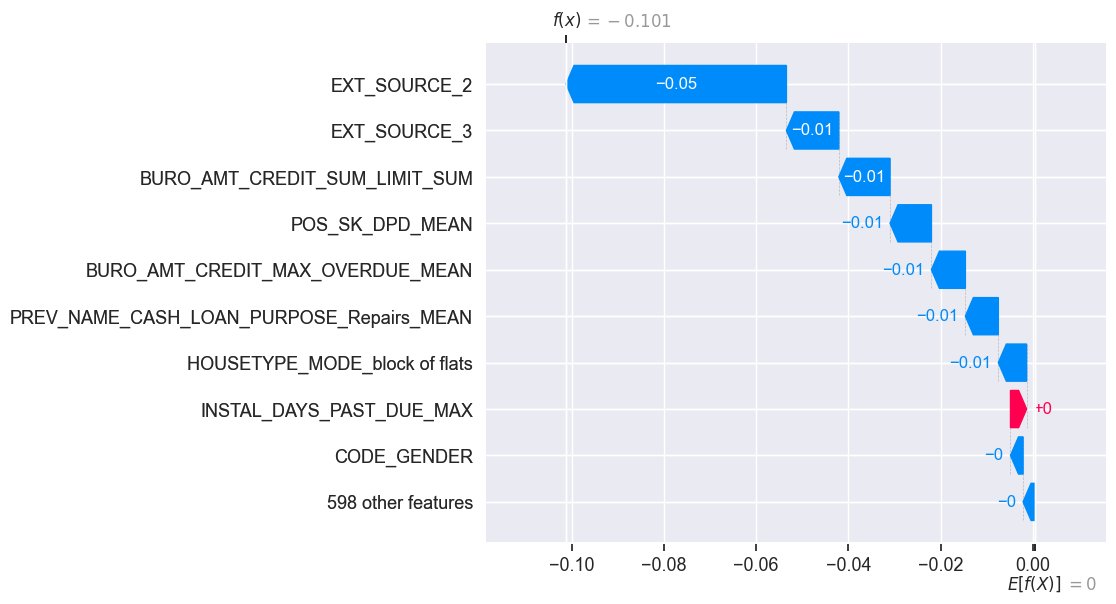

In [104]:
# Select the last customer from the test dataset
client_index = 6150  # This is the index of the client we want to analyze

# Reshape the client's data to ensure it is in a 2D array format
client_data = x_test_prepared[client_index].reshape(1, -1)  # This is necessary for the model's predict function

# Compute the SHAP values for this specific client
client_shap_values = explainer.shap_values(client_data)  # SHAP values explain the impact of each feature for this single prediction

# Visualize the results using a waterfall plot
# The waterfall plot will help us understand how each feature contributes to the model's output for this client
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, client_shap_values[0], feature_names=feature_names)

#### Force plot

In [105]:
# Displayforce plot
shap.initjs()
shap.force_plot(explainer.expected_value, client_shap_values, client_data, feature_names=feature_names)


Cela représente une métrique interne propre à l'algorithme XGBoost, qui est différente de la méthode SHAP.

I use the XGBoost feature_importances_ built in method to get the feature importance of the trained model.

# Export data for api and dashboard

In [106]:
import joblib

# Exporter le SHAP explainer
explainer_path = '../models/shap_explainer.pkl'
joblib.dump(shap_explainer, explainer_path)
print(f"SHAP explainer saved to {explainer_path}")


SHAP explainer saved to ../models/shap_explainer.pkl


# Test SHAP sur les nouvelles entrées

In [107]:
""" utile ?
from sklearn.base import BaseEstimator, ClassifierMixin

# Classe pour appliquer le threshold sur les probabilités
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, threshold=0.45):
        self.model = model
        self.threshold = threshold

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        # Prédictions probabilistes
        y_proba = self.model.predict_proba(X)[:, 1]
        # Appliquer le threshold
        return (y_proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        # Retourner les probabilités
        return self.model.predict_proba(X)"""


' utile ?\nfrom sklearn.base import BaseEstimator, ClassifierMixin\n\n# Classe pour appliquer le threshold sur les probabilités\nclass ThresholdClassifier(BaseEstimator, ClassifierMixin):\n    def __init__(self, model, threshold=0.45):\n        self.model = model\n        self.threshold = threshold\n\n    def fit(self, X, y):\n        self.model.fit(X, y)\n        return self\n\n    def predict(self, X):\n        # Prédictions probabilistes\n        y_proba = self.model.predict_proba(X)[:, 1]\n        # Appliquer le threshold\n        return (y_proba >= self.threshold).astype(int)\n\n    def predict_proba(self, X):\n        # Retourner les probabilités\n        return self.model.predict_proba(X)'

In [108]:
new_data = pd.read_csv("../data/processed/test_feature_engineering_sample.csv")
new_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,218796.0,0,1,0,0,0,103500.0,280170.0,29547.0,0.018029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202006.0,0,1,0,0,1,202500.0,383787.0,33070.5,0.018850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123688.0,0,1,0,0,1,157500.0,440784.0,34956.0,0.002134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,389440.0,0,1,0,0,0,90000.0,189000.0,12757.5,0.015221,...,False,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0
4,166255.0,0,1,0,0,0,135000.0,450000.0,19197.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
import joblib

# Charger le pipeline complet (prétraitement + modèle)
loaded_pipeline = joblib.load("../models/xgb_pipeline_tuned.pkl")

# Supposons que "new_data" représente vos nouvelles données de test sans la colonne 'TARGET'
# Le pipeline prétraitera et prédira directement
y_pred_new = loaded_pipeline.predict(new_data)

print("Prédictions pour les nouvelles données : ", y_pred_new)


Prédictions pour les nouvelles données :  [0 0 0 ... 0 0 0]


/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


/Users/laureagrech/oc7_venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


SHAP Bar plot (global feature importance) for new data:


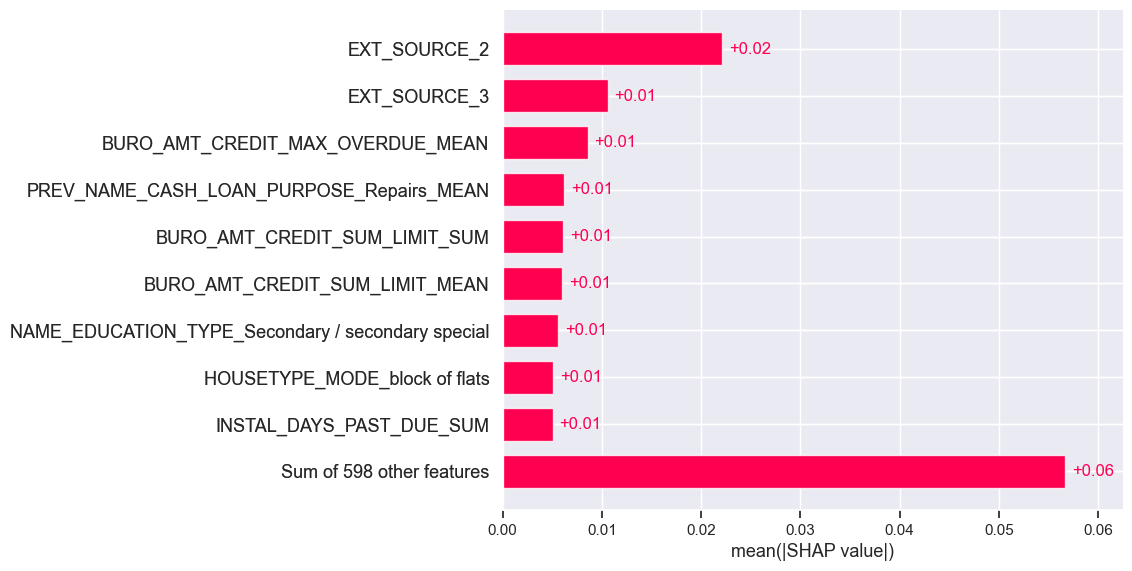

SHAP Waterfall plot for new data instance 4873:


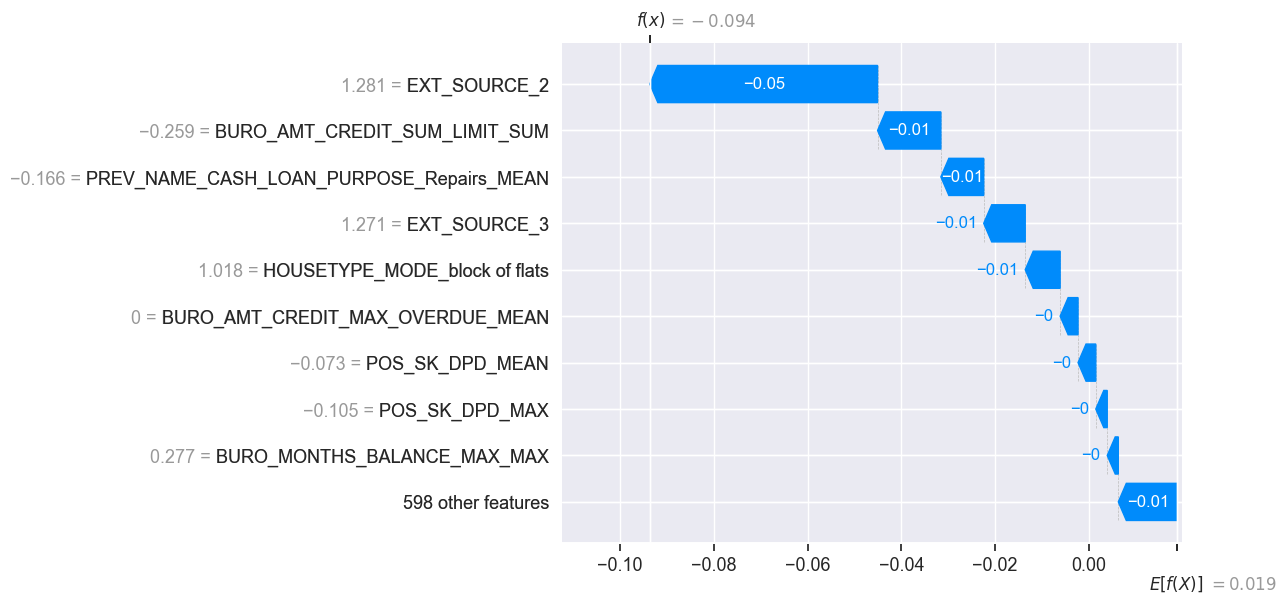

In [111]:
import joblib
import shap

# Chemin vers le fichier du pipeline complet
model_path = "../models/xgb_pipeline_tuned.pkl"
explainer_path = "../models/shap_explainer.pkl"

# Charger le pipeline complet (prétraitement + modèle)
loaded_pipeline = joblib.load(model_path)

# Charge le SHAP explainer sauvegardé
loaded_shap_explainer = joblib.load(explainer_path)

# "new_data" représente les nouvelles données de test
# On utilise le pipeline chargé pour prétraiter les nouvelles données
new_data_prepared = loaded_pipeline.named_steps['preprocessing'].transform(new_data)

# Calcul des valeurs SHAP pour les nouvelles données
shap_values_new_data = loaded_shap_explainer(new_data_prepared)

# Affichage des valeurs SHAP sous forme de graphique Bar pour les nouvelles données
print("SHAP Bar plot (global feature importance) for new data:")
shap.plots.bar(shap_values_new_data)

# Affichage des valeurs SHAP sous forme de graphique Waterfall pour une instance spécifique
valid_idx_new_data = len(new_data_prepared) - 1  # ici pour l'exemple on prend la dernière instance
print(f"SHAP Waterfall plot for new data instance {valid_idx_new_data}:")
shap.plots.waterfall(shap_values_new_data[valid_idx_new_data])


on fait des prédictions sur des données prétraitées mais non rééquilibrées.

I export the XGBoost default model (selected as best model)

I export the SHAP explainer based on the XGBoost default model.

In [113]:
import os
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score, classification_report
import xgboost as xgb
import joblib
import numpy as np

# Classe CustomThreshold pour sauvegarder le seuil
class CustomThreshold:
    def __init__(self, model, threshold=0.4650724232196808):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def get_threshold(self):
        return self.threshold

# Fonction pour optimiser et entraîner le modèle avec XGBoost
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10, threshold=0.4650724232196808):
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    
    # Split des données
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Pipeline de prétraitement (ceci est commun pour entraînement et prédiction)
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
    ])
    
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Rééquilibrage uniquement sur les données d'entraînement
    smote = SMOTE(sampling_strategy=0.5, random_state=random_state)
    undersample = RandomUnderSampler(sampling_strategy=1, random_state=random_state)
    
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_prepared, y_train)
    x_train_resampled, y_train_resampled = undersample.fit_resample(x_train_resampled, y_train_resampled)

    # Espace des hyperparamètres pour XGBoost
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    # Fonction objectif pour Hyperopt
    def objective(params):
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
        return {'loss': -score, 'status': STATUS_OK}

    try:
        mlflow.start_run()

        # Optimisation des hyperparamètres
        trials = Trials()
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Entraînement du modèle optimisé avec les meilleurs hyperparamètres
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Ajout du CustomThreshold au pipeline
        custom_model = CustomThreshold(best_model, threshold=threshold)

        # Création du pipeline complet (sans rééquilibrage pour la prédiction)
        full_pipeline = Pipeline(steps=[
            ('preprocessing', preprocess_pipeline),  # Inclut l'imputation et la normalisation
            ('model', custom_model)  # Modèle optimisé avec seuil
        ])

        # Sauvegarder le pipeline complet
        model_path = "../models/xgb_pipeline_tuned.pkl"
        joblib.dump(full_pipeline, model_path)

        # Prédictions de probabilités sur le jeu de test
        y_pred_proba_optimized = best_model.predict_proba(x_test_prepared)[:, 1]

        # Prédictions binaires en utilisant le threshold fixe
        y_pred_optimized = (y_pred_proba_optimized >= threshold).astype(int)

        # Calcul du F-beta score avec le threshold
        final_fbeta_optimized = fbeta_score(y_test, y_pred_optimized, beta=beta)
        clf_report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)

        # Enregistrer le modèle et les métriques dans MLflow
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta_optimized", final_fbeta_optimized)

        print(f"Optimized model F-beta (beta={beta}, threshold={threshold}): {final_fbeta_optimized}")
    
    finally:
        mlflow.end_run()

    # Retourner les données nécessaires + best_model explicitement
    return (full_pipeline, best_model, final_fbeta_optimized, best_params, clf_report_optimized, 
            y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized)


# Appel de la fonction avec les données et récupération de tous les paramètres
(full_pipeline, best_model, final_fbeta_optimized, best_hyperparams, clf_report_optimized, 
 y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized) = optimize_xgb(data)


# Affichage des résultats
print("=== Optimized Model Classification Report ===")
print(clf_report_optimized)


100%|██████████| 10/10 [03:21<00:00, 20.14s/trial, best loss: -0.8189852644214886]
Optimized model F-beta (beta=2, threshold=0.4650724232196808): 0.34430379746835443
=== Optimized Model Classification Report ===
{'0.0': {'precision': 0.959045904590459, 'recall': 0.377034677990092, 'f1-score': 0.5412750825501651, 'support': 5652.0}, '1.0': {'precision': 0.1038432171035887, 'recall': 0.8176352705410822, 'f1-score': 0.1842818428184282, 'support': 499.0}, 'accuracy': 0.4127784100146318, 'macro avg': {'precision': 0.5314445608470239, 'recall': 0.5973349742655871, 'f1-score': 0.36277846268429664, 'support': 6151.0}, 'weighted avg': {'precision': 0.8896675691887442, 'recall': 0.4127784100146318, 'f1-score': 0.5123139987221473, 'support': 6151.0}}


In [114]:
import shap

# Créer un explainer SHAP après l'entraînement du modèle
explainer = shap.TreeExplainer(best_model)

# Sauvegarder l'explainer SHAP
explainer_path = "../models/shap_explainer.pkl"
joblib.dump(explainer, explainer_path)
print(f"SHAP explainer saved to {explainer_path}")


SHAP explainer saved to ../models/shap_explainer.pkl


# Code api : local

In [ ]:
"""


Modèle qui retourne le best model xgboost, le shap explainer et le csv sample /Users/laureagrech/Desktop/OC7/data/processed/train_feature_engineering_sample.csv
L'api comprend :
 1/ une fonction qui prend en param un ID client et retourne la prédiction

  2/ une fonction qui prend un ID client et qui retourne les données du client

  3/ une fonction qui prend un ID et retournes les Shap values du client.



fais en sorte de créer un dashboard streamlit qui me permet à partir de l'api de sélectionner un utilisateur (id) du dataset sample et de retourner son score sous forme de jauge (rouge si score mauvais et vert si bon score et crédita accordé), le shap explainer des features de ce client par rapport au dataset ainsin que un deux graphiques sous forme de boxplot et barplot qui compare le client et une feature sélectionné par rapport à la moyenne des autres clients sur cette feature
Le dashboard permet donc de séléctionner un client et une variable avec 4 graphiques dont deux intéractifs où la variable est comparée

explique comment je peux déployer les 2 (l'api et le dashoboard) avec aws ec2

Explique chaque étape et tout le code ce qu’il permet d’afficher ainsi que la manière de faire marcher et l’api et le dashboard sur ans ou localement	


"""

In [ ]:
# Lancer l'API avec : uvicorn main:app --reload

In [ ]:
from fastapi import FastAPI, HTTPException
import joblib
import pandas as pd
import numpy as np

# Load the full pipeline which includes preprocessing and the trained model
pipeline_path = "../models/xgb_pipeline_tuned.pkl"
loaded_pipeline = joblib.load(pipeline_path)

# Load the SHAP explainer for model interpretation
explainer_path = "../models/shap_explainer.pkl"
loaded_shap_explainer = joblib.load(explainer_path)

# Initialize the FastAPI application
app = FastAPI()

# Load the client data from a CSV file into a DataFrame
# This data will be used for predicting and analyzing client-specific results
data_clients = pd.read_csv("../data/processed/test_feature_engineering_sample.csv")

# Ensure that the SK_ID_CURR column is treated as floats for consistency
# Important for accurate merging and retrieval based on client IDs
data_clients['SK_ID_CURR'] = data_clients['SK_ID_CURR'].astype(float)

# Debugging: Confirm that the client data has been successfully loaded
print(f"Data loaded successfully with {len(data_clients)} rows.")

# Define an endpoint to retrieve client data
data_clients = pd.read_csv("../data/processed/test_feature_engineering_sample.csv")

# Function to retrieve client data based on ID
@app.get("/client_data/{client_id}")
def get_client_data(client_id: int):
    try:
        # Convert client ID to float for consistency with data storage format
        client_id_as_float = float(client_id)
        
        # Ensure the SK_ID_CURR column is treated as a float
data_clients['SK_ID_CURR'] = data_clients['SK_ID_CURR'].astype(float)
        
        # Locate the specific client data within the DataFrame
        client_data = data_clients[data_clients["SK_ID_CURR"] == client_id_as_float]
        
        # Check if the client data was found, and return an error if not
        if client_data.empty:
            raise HTTPException(status_code=404, detail=f"Client {client_id} not found.")
        
        # Replace any NaN values in the client data with defaults
        # In this case, replace with None or an appropriate placeholder
        client_data = client_data.replace({np.nan: None})  # Replace NaNs for easier JSON serialization
        
        # Return the client data in JSON format
        return {"data": client_data.to_dict(orient="records")}
    
    except Exception as e:
        # Log and raise a detailed error if an exception occurs
        print(f"Error in retrieving client data: {e}")
        raise HTTPException(status_code=500, detail=f"Internal server error: {str(e)}")


# Define an endpoint to get a prediction for a client based on their ID
@app.get("/prediction/{client_id}")
def get_prediction(client_id: int):
    try:
        # Convert client ID to float to ensure consistency with dataset indexing
        client_id_as_float = float(client_id)
        
        # Debug: Verify the input ID matches expected format
        print(f"Searching for client: {client_id_as_float}")
        
        # Retrieve client data and remove the TARGET column if present
        client_data = data_clients[data_clients["SK_ID_CURR"] == client_id_as_float].drop(columns=["TARGET"], errors='ignore')
        
        # Check if the client data is found, else log an error
        if client_data.empty:
            print(f"Client {client_id_as_float} not found!")
            raise HTTPException(status_code=404, detail="Client not found")
        
        print(f"Found client data: {client_data.head()}")

        # Convert DataFrame to NumPy array for model prediction, avoiding feature name warnings
        client_data_np = client_data.to_numpy()
        
        # Debug: Confirm conversion maintains correct data shape
        print(f"Client data shape: {client_data_np.shape}")

        # Compute prediction probability and retrieve set threshold for decision making
        prediction_proba = loaded_pipeline.predict_proba(client_data_np)[:, 1][0]
        threshold = loaded_pipeline.named_steps['model'].get_threshold()

        print(f"Prediction: {prediction_proba}, Threshold: {threshold}")
        
        # Ensure result types are JSON compatible by converting to standard Python float
        return {"score": float(prediction_proba), "threshold": float(threshold)}
    
    except Exception as e:
        # Handle unexpected errors gracefully with server error message
        print(f"Error in prediction: {e}")
        raise HTTPException(status_code=500, detail=f"Internal Server Error: {str(e)}")


# Define an endpoint to retrieve SHAP values for a given client ID
@app.get("/shap_values/{client_id}")
def get_shap_values(client_id: int):
    try:
        # Convert client ID to a float to support matching against dataset types
        client_id_as_float = float(client_id)
        
        # Debug: Output client ID retrieval for logging
        print(f"Getting SHAP values for client: {client_id_as_float}")
        
        # Retrieve data for the specified client, ignoring TARGET column
        client_data = data_clients[data_clients["SK_ID_CURR"] == client_id_as_float].drop(columns=["TARGET"], errors='ignore')
        
        # Raise an error if client data is not found
        if client_data.empty:
            print(f"Client {client_id_as_float} not found!")
            raise HTTPException(status_code=404, detail="Client not found")

        # Prepare the client data for SHAP processing by reshaping as needed
        client_data_np = client_data.to_numpy().reshape(1, -1)  # Ensure data is 2D for SHAP explainer

        # Debug: Confirm data shape is suitable for SHAP analysis
        print(f"Client data shape for SHAP: {client_data_np.shape}")

        # Calculate SHAP values to explain model prediction
        client_shap_values = loaded_shap_explainer.shap_values(client_data_np)

        # Return SHAP values in a JSON-friendly format
        return {"shap_values": client_shap_values.tolist()}
    
    except Exception as e:
        # Provide detailed error messages for smoother debugging
        print(f"Error in getting SHAP values: {e}")
        raise HTTPException(status_code=500, detail=f"Internal Server Error: {str(e)}")

# Code dashboard : local

In [ ]:
""" 
tuto : https://www.youtube.com/watch?v=SgSnz7kW-Ko 
Le dashboard affiche :
La prédiction du modèle (accordé ou non).
Le score associé à cette prédiction (en pourcentage).
Les variables du client sélectionné.
Une comparaison des variables du client par rapport à la population (moyenne et distribution).
Une explication de la prédiction grâce à SHAP (importance des variables)
"""

In [ ]:
"""Lancement du dashboard :
Lancez l'API en exécutant Uvicorn :

bash
Copier le code
uvicorn api:app --reload
Lancez le dashboard Streamlit avec la commande :

bash
Copier le code
streamlit run streamlit_dashboard.py
Accédez à votre tableau de bord à l'adresse affichée, généralement http://localhost:8501"""

In [ ]:
import streamlit as st
import requests
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import joblib
import numpy as np

# Set the base URL for the API that provides the data needed by the dashboard
api_url = "http://127.0.0.1:8000"

# Load the SHAP explainer from the file system; this will be used to interpret prediction outputs
explainer = joblib.load("../models/shap_explainer.pkl")

# Set the title of the Streamlit app
st.title("Tableau de bord de Prédiction du Crédit")

# Create a text input field for user to enter a client ID, with default value as "218796"
client_id = st.text_input("Entrez l'ID du client", "218796")
# Add a button to submit client ID for fetching data and predictions
validate_button = st.button("Valider")

# Check if the validate button is clicked
if validate_button:
    # Construct the API URL to fetch client data using the provided client ID
    client_data_url = f"{api_url}/client_data/{client_id}"
    # Send a GET request to the API to get the client's data
    client_response = requests.get(client_data_url).json()
    
    # Check if the response contains an error
    if "error" in client_response:
        # Display the error message if there is one
        st.error(f"Erreur : {client_response['error']}")
    else:
        # Otherwise, convert the response data to a DataFrame
        client_data = pd.DataFrame(client_response['data'])
        
        # Display the client data on the dashboard
        st.subheader("Données du client")
        st.write(client_data)

        # Start analysis section: Compare a specific feature between the client and population
        st.subheader("Comparaison de la variable EXT_SOURCE_3 entre le client et la moyenne")
        # The feature to compare
        feature = "EXT_SOURCE_3"
        # Extract the client's specific feature value
        client_value = client_data[feature].values[0]
        
        # Load all client data from the dataset to compute the mean value
        all_data = pd.read_csv("../data/processed/test_feature_engineering_sample.csv")
        # Calculate the mean value of the selected feature in the whole dataset
        mean_value = all_data[feature].mean()
        
        # Create a subplot with one row and two columns for visualization
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
        # On the first plot, show the client's feature value compared to the average
        sns.barplot(x=["client", "moyenne"], y=[client_value, mean_value], ax=ax[0])
        ax[0].set_title("Comparaison du client à la moyenne")
        
        # On the second plot, show the distribution of this feature in the entire dataset
        sns.boxplot(x=all_data[feature], ax=ax[1])
        ax[1].set_title(f"Répartition de la variable {feature} dans la clientèle")
        
        # Use Streamlit to display the matplotlib figure
        st.pyplot(fig)

        # Construct the API URL to get predictions for the client
        prediction_url = f"{api_url}/prediction/{client_id}"
        # Fetch the model prediction and threshold using the client ID
        prediction_response = requests.get(prediction_url).json()
        prediction_score = prediction_response['score']
        threshold = prediction_response['threshold']

        # Convert the prediction score to a percentage format
        prediction_percentage = round(prediction_score * 100, 2)
        
        # Display prediction results as descriptive text explaining the prediction score and threshold logic
        st.subheader("Résultat de la prédiction")
        st.markdown(f"""
            **Explication du score :**
            - Ce score de **{prediction_percentage}%** est une estimation de la probabilité que ce client **ne rembourse pas** le crédit (score = 1).
            - Si ce score dépasse le seuil de **{round(threshold * 100, 2)}%**, le crédit est **refusé**.
            - En dessous de ce seuil, le crédit est **accordé**.
        """)
        
        # Determine if the credit is granted or denied based on prediction score thresholds
        score_text = "Crédit refusé" if prediction_score >= threshold else "Crédit accordé"

        # Create a gauge chart to visually represent the prediction score against the threshold
        fig_gauge = go.Figure(go.Indicator(
            mode="gauge+number",
            value=prediction_score * 100,  # Score converted to percentage
            title={'text': f"Score de Prédiction: {prediction_percentage}%"},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "black"},
                'steps': [
                    {'range': [0, threshold * 100], 'color': "green"},
                    {'range': [threshold * 100, 100], 'color': "red"},
                ],
                'threshold': {
                    'line': {'color': "blue", 'width': 4},
                    'thickness': 0.75,
                    'value': threshold * 100  # Threshold line
                }
            }
        ))

        # Display the gauge chart on the dashboard
        st.plotly_chart(fig_gauge)

        # Show a conclusive message regarding the client's credit application status
        st.markdown(f"**Décision :** {score_text} (Seuil: {round(threshold * 100, 2)}%)")

        # Call the API to fetch local SHAP values for the client
        shap_values_url = f"{api_url}/shap_values/{client_id}"
        shap_response = requests.get(shap_values_url).json()
        shap_values = shap_response['shap_values']

        # Convert SHAP values to a numpy array to facilitate plotting
        shap_values_np = np.array(shap_values[0])

        # Handling expected values for SHAP explanation: use first element for multi-class models
        if isinstance(explainer.expected_value, np.ndarray) and len(explainer.expected_value) > 1:
            base_value = explainer.expected_value[0]  # Multi-class model
        else:
            base_value = float(explainer.expected_value)  # Binary model

        # Display the expected model value before individual feature contributions
        st.subheader("Valeur attendue (Expected Value)")
        st.markdown(f"La valeur attendue du modèle est : **{round(base_value, 4)}**.")
        st.markdown("C'est la prédiction moyenne du modèle avant de prendre en compte les contributions spécifiques de chaque variable.")

        # **Waterfall plot**: Show detailed SHAP analysis for the client
        st.subheader("Analyse locale des SHAP values : Contribution spécifique de chaque feature pour ce client")
        st.markdown("Ce graphique montre comment les différentes features influencent la prédiction pour ce client particulier. Chaque barre indique l'impact d'une feature qui pousse la prédiction soit vers le haut, soit vers le bas.")
        # Create a Waterfall plot using SHAP to visualize contributions of each feature
        fig_local = plt.figure(figsize=(10, 6))
        shap.waterfall_plot(shap.Explanation(values=shap_values_np, base_values=base_value, data=client_data.iloc[0,:]), show=False)
        # Display the Waterfall plot on the dashboard
        st.pyplot(fig_local)

        # **Bar plot**: Show global SHAP analysis across all clients
        st.subheader("Analyse globale des SHAP values : Importance des features à travers tous les clients")
        st.markdown("Ce graphique montre quelles features sont globalement les plus importantes pour le modèle, en moyenne, à travers tous les clients.")
        # Create a summary plot with SHAP to see global feature importance
        fig_global = plt.figure(figsize=(10, 6))
        shap.summary_plot(np.array(shap_values), client_data, plot_type="bar", show=False)
        # Display the summary bar plot on the dashboard
        st.pyplot(fig_global)

### API code for online use

In [ ]:
# This code implements an API using FastAPI to serve predictions and explanations for a credit model. 
# The model utilizes a pre-trained pipeline and SHAP (SHapley Additive exPlanations) values to interpret predictions.

from fastapi import FastAPI, HTTPException
import joblib
import pandas as pd
import numpy as np

# Load the complete pipeline which includes both preprocessing steps and the trained XGBoost model.
pipeline_path = "xgb_pipeline_tuned.pkl"
loaded_pipeline = joblib.load(pipeline_path)

# Load the SHAP explainer for interpreting the model's predictions.
explainer_path = "shap_explainer.pkl"
loaded_shap_explainer = joblib.load(explainer_path)

# Create an instance of the FastAPI to build the web API.
app = FastAPI()

# Load client data from a CSV file. This data includes the feature set required for predictions.
data_clients = pd.read_csv("test_feature_engineering_sample.csv")

# Define an endpoint to get client data by client ID.
@app.get("/client_data/{client_id}")
# Function to fetch client data when provided with a specific client ID.
def get_client_data(client_id: int):
    # Select rows where the client ID matches the provided value.
    client_data = data_clients[data_clients["SK_ID_CURR"] == float(client_id)]
    # If no data is found, return a 404 error.
    if client_data.empty:
        raise HTTPException(status_code=404, detail="Client not found")
    # Return the client's data as JSON.
    return {"data": client_data.to_dict(orient="records")}

# Define an endpoint to make predictions for a given client ID.
@app.get("/prediction/{client_id}")
# Function that returns a prediction score and threshold for a particular client.
def get_prediction(client_id: int):
    # Extract the data for the specified client and drop the TARGET column if it exists.
    client_data = data_clients[data_clients["SK_ID_CURR"] == float(client_id)].drop(columns=["TARGET"], errors='ignore')
    # If no data is found for the client, return a 404 error.
    if client_data.empty:
        raise HTTPException(status_code=404, detail="Client not found")
    # Use the loaded pipeline to predict probabilities.
    prediction_proba = loaded_pipeline.predict_proba(client_data.to_numpy())[:, 1][0]  # Extract the prediction probability for the positive class.
    # Retrieve the decision threshold used by the loaded model.
    threshold = loaded_pipeline.named_steps['model'].get_threshold()
    # Return the prediction probability and threshold as a response.
    return {"score": float(prediction_proba), "threshold": float(threshold)}

# Define an endpoint to obtain SHAP values, which explain the prediction for a specific client ID.
@app.get("/shap_values/{client_id}")
# Function that returns SHAP values for the specified client.
def get_shap_values(client_id: int):
    # Retrieve data for the client and drop the TARGET column if present.
    client_data = data_clients[data_clients["SK_ID_CURR"] == float(client_id)].drop(columns=["TARGET"], errors='ignore')
    # If the client data set is empty, return a 404 error.
    if client_data.empty:
        raise HTTPException(status_code=404, detail="Client not found")
    # Compute SHAP values for the retrieved client data.
    client_shap_values = loaded_shap_explainer.shap_values(client_data.to_numpy())
    # Return the computed SHAP values.
    return {"shap_values": client_shap_values.tolist()}

### Dashboard Code for online use

In [ ]:

import streamlit as st
import requests
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import joblib
import numpy as np

# API URL
api_url = "public IP address of of API EC2 instance."

# Load the SHAP explainer
explainer = joblib.load("shap_explainer.pkl")

# Dashboard title
st.title("Credit Prediction Dashboard")

# Client ID selection
client_id = st.text_input("Enter Client ID", "218796")
validate_button = st.button("Validate")

if validate_button:
    client_data_url = f"{api_url}/client_data/{client_id}"
    client_response = requests.get(client_data_url).json()
    
    if "error" in client_response:
        st.error(f"Error: {client_response['error']}")
    else:
        client_data = pd.DataFrame(client_response['data'])
        st.subheader("Client Data")
        st.write(client_data)

        feature = "EXT_SOURCE_3"
        client_value = client_data[feature].values[0]
        all_data = pd.read_csv("test_feature_engineering_sample.csv")
        mean_value = all_data[feature].mean()
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        sns.barplot(x=["client", "mean"], y=[client_value, mean_value], ax=ax[0])
        ax[0].set_title("Client vs Mean")
        sns.boxplot(x=all_data[feature], ax=ax[1])
        ax[1].set_title(f"Distribution of {feature}")
        st.pyplot(fig)

        prediction_url = f"{api_url}/prediction/{client_id}"
        prediction_response = requests.get(prediction_url).json()
        prediction_score = prediction_response['score']
        threshold = prediction_response['threshold']

        prediction_percentage = round(prediction_score * 100, 2)
        st.subheader("Prediction Result")
        st.markdown(f"**Score:** {prediction_percentage}%")
        
        score_text = "Credit Denied" if prediction_score >= threshold else "Credit Approved"
        fig_gauge = go.Figure(go.Indicator(
            mode="gauge+number",
            value=prediction_score * 100,
            title={'text': f"Prediction Score: {prediction_percentage}%"},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "black"},
                'steps': [
                    {'range': [0, threshold * 100], 'color': "green"},
                    {'range': [threshold * 100, 100], 'color': "red"},
                ],
                'threshold': {
                    'line': {'color': "blue", 'width': 4},
                    'thickness': 0.75,
                    'value': threshold * 100
                }
            }
        ))
        st.plotly_chart(fig_gauge)
        st.markdown(f"**Decision:** {score_text}")

        shap_values_url = f"{api_url}/shap_values/{client_id}"
        shap_response = requests.get(shap_values_url).json()
        shap_values = shap_response['shap_values']
        shap_values_np = np.array(shap_values[0])

        if isinstance(explainer.expected_value, np.ndarray) and len(explainer.expected_value) > 1:
            base_value = explainer.expected_value[0]
        else:
            base_value = float(explainer.expected_value)

        st.subheader("Expected Value")
        st.markdown(f"The model's expected value is: **{round(base_value, 4)}**.")

        st.subheader("Local SHAP Analysis")
        fig_local = plt.figure(figsize=(10, 6))
        shap.waterfall_plot(shap.Explanation(values=shap_values_np, base_values=base_value, data=client_data.iloc[0,:]), show=False)
        st.pyplot(fig_local)

        st.subheader("Global SHAP Analysis")
        fig_global = plt.figure(figsize=(10, 6))
        shap.summary_plot(np.array(shap_values), client_data, plot_type="bar", show=False)
        st.pyplot(fig_global)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=771d53aa-1bab-4ccc-9ccb-dc01425d5914' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>